# 《金融计算》 & 《量化投资》课程期末实验设计

注：由于课程论文的要求需要**金融化、学术化**，而本项目个人认为更多还是偏LLM的计算机AI方向的应用，所以会复用一些函数，但不会全部使用，尤其Agent协作部分，由于每次LLM生成的不确定性，会谨慎纳入考量。

Python环境与本项目使用的一致。

# A股市场人工智能驱动量化投资策略

本策略实验基于深度学习、强化学习和行为金融学理论，结合A股市场特征，构建一个完整的量化投资系统。

涵盖四个基本金融主题：资产定价、资产配置、交易执行和风险管理。


## 一、环境准备与依赖库导入

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import akshare as ak
import talib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import warnings
import shap
from arch import arch_model
import time
import random

In [36]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可复现
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

In [37]:
# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 二、数据获取与处理

使用AKShare获取A股市场数据，包括价格数据、基本面数据和宏观经济数据等。

In [38]:
start_date = '20100101'
end_date = '20250331'

In [39]:
def get_stock_pool():
    """获取沪深300和中证500成分股作为股票池"""
    print("获取沪深300成分股...")
    hs300_stocks = ak.index_stock_cons_sina(symbol="000300")
    print("获取中证500成分股...")
    zz500_stocks = ak.index_stock_cons_sina(symbol="000905")
    
    # 合并股票池并去重
    stock_pool = pd.concat([hs300_stocks, zz500_stocks], axis=0)
    stock_pool = stock_pool.drop_duplicates(subset=['code'])
    
    # 将股票代码格式化为带市场前缀的格式
    stock_pool['formatted_code'] = stock_pool['code'].apply(
        lambda x: f"sh{x}" if x.startswith('6') else f"sz{x}")
    
    print(f"股票池大小: {len(stock_pool)}")
    return stock_pool

# 获取股票池
stock_pool = get_stock_pool()

stock_pool.head()

获取沪深300成分股...
获取中证500成分股...
股票池大小: 800


,symbol,code,name,trade,pricechange,changepercent,buy,sell,settlement,open,high,low,volume,amount,ticktime,per,pb,mktcap,nmc,turnoverratio,formatted_code
0,sh600000,600000,浦发银行,11.770,0.14,1.204,11.760,11.770,11.630,11.650,11.880,11.620,38675249,455345383,10:54:56,8.654,0.518,3.454751e+07,3.454751e+07,0.13176,sh600000
1,sh600009,600009,上海机场,32.120,-0.2,-0.619,32.110,32.120,32.320,32.310,32.350,32.110,2365909,76204267,10:54:56,41.179,1.895,7.993002e+06,6.162851e+06,0.12331,sh600009
2,sh600010,600010,包钢股份,1.800,-0.02,-1.099,1.790,1.800,1.820,1.820,1.820,1.790,136200220,245391705,10:54:56,310.345,1.569,8.151951e+06,5.648544e+06,0.43402,sh600010
3,sh600011,600011,华能国际,7.470,0.15,2.049,7.460,7.470,7.320,7.320,7.550,7.320,57600591,429274164,10:54:56,16.239,1.895,1.172648e+07,8.215289e+06,0.52375,sh600011
4,sh600015,600015,华夏银行,7.330,0.05,0.687,7.320,7.330,7.280,7.290,7.390,7.290,57290585,420931575,10:54:56,4.525,0.382,1.166564e+07,1.127884e+07,0.37233,sh600015


In [40]:
def get_stock_data(stock_code, start_date, end_date):
    """获取单只股票的历史行情数据"""
    try:
        # 调用AKShare获取日线数据
        df = ak.stock_zh_a_hist(symbol=stock_code, period="daily", 
                              start_date=start_date, end_date=end_date, adjust="qfq")
        
        # 重命名列，使列名更加统一
        df = df.rename(columns={
            '日期': 'date',
            '开盘': 'open',
            '最高': 'high',
            '最低': 'low',
            '收盘': 'close',
            '成交量': 'volume',
            '成交额': 'amount',
            '振幅': 'amplitude',
            '涨跌幅': 'pct_chg',
            '涨跌额': 'change',
            '换手率': 'turnover'
        })
        
        # 将日期列转换为日期类型并设为索引
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        df['stock_code'] = stock_code
        
        return df
    except Exception as e:
        print(f"获取{stock_code}数据失败：{e}")
        return None

In [41]:
# 我们选取沪深300前100只股票来构建数据集
sample_stocks = stock_pool.head(100)
print("选取的样本股票：")
sample_stocks 

选取的样本股票：


,symbol,code,name,trade,pricechange,changepercent,buy,sell,settlement,open,high,low,volume,amount,ticktime,per,pb,mktcap,nmc,turnoverratio,formatted_code
0,sh600000,600000,浦发银行,11.770,0.14,1.204,11.760,11.770,11.630,11.650,11.880,11.620,38675249,455345383,10:54:56,8.654,0.518,3.454751e+07,3.454751e+07,0.13176,sh600000
1,sh600009,600009,上海机场,32.120,-0.2,-0.619,32.110,32.120,32.320,32.310,32.350,32.110,2365909,76204267,10:54:56,41.179,1.895,7.993002e+06,6.162851e+06,0.12331,sh600009
2,sh600010,600010,包钢股份,1.800,-0.02,-1.099,1.790,1.800,1.820,1.820,1.820,1.790,136200220,245391705,10:54:56,310.345,1.569,8.151951e+06,5.648544e+06,0.43402,sh600010
3,sh600011,600011,华能国际,7.470,0.15,2.049,7.460,7.470,7.320,7.320,7.550,7.320,57600591,429274164,10:54:56,16.239,1.895,1.172648e+07,8.215289e+06,0.52375,sh600011
4,sh600015,600015,华夏银行,7.330,0.05,0.687,7.320,7.330,7.280,7.290,7.390,7.290,57290585,420931575,10:54:56,4.525,0.382,1.166564e+07,1.127884e+07,0.37233,sh600015
5,sh600016,600016,民生银行,4.080,0.02,0.493,4.080,4.090,4.060,4.070,4.100,4.060,87874768,359109584,10:54:54,6.375,0.321,1.786323e+07,1.446855e+07,0.24780,sh600016
6,sh600018,600018,上港集团,5.590,0.04,0.721,5.590,5.600,5.550,5.560,5.610,5.550,16237620,90737817,10:54:55,8.680,0.946,1.301428e+07,1.297695e+07,0.06995,sh600018
7,sh600019,600019,宝钢股份,6.860,-0.02,-0.291,6.860,6.870,6.880,6.890,6.920,6.860,12747656,87876588,10:54:55,20.176,0.740,1.502933e+07,1.494251e+07,0.05852,sh600019
8,sh600023,600023,浙能电力,5.340,0.01,0.188,5.340,5.350,5.330,5.330,5.370,5.310,23215221,124099079,10:54:54,9.207,0.958,7.160263e+06,7.160263e+06,0.17314,sh600023
9,sh600025,600025,华能水电,9.840,0.22,2.287,9.830,9.840,9.620,9.650,9.880,9.630,29302100,287087635,10:54:56,22.364,2.927,1.771200e+07,1.771200e+07,0.16279,sh600025


In [42]:
# 获取样本股票的行情数据
stock_data_dict = {}
cnt = 0 # 跳过的股票数
for idx, row in sample_stocks.iterrows():
    stock_code = row['code']
    formatted_code = row['formatted_code']
    print(f"获取 {stock_code} ({row['name']}) 的数据...")
    
    stock_data = get_stock_data(stock_code, start_date, end_date)
    if stock_data is not None:
        # 检查数据的开始年份是否为2010年
        start_year = stock_data.index.min().year
        if start_year == 2010:
            stock_data_dict[formatted_code] = stock_data
            print(f"已获取 {stock_code} 数据，时间范围: {stock_data.index.min()} 到 {stock_data.index.max()}")
        else:
            print(f"跳过 {stock_code}，因为开始年份为 {start_year}，不是2010年")
            cnt += 1
    else:
        cnt += 1
        print(f"跳过 {stock_code}")

获取 600000 (浦发银行) 的数据...
已获取 600000 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600009 (上海机场) 的数据...
已获取 600009 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600010 (包钢股份) 的数据...
已获取 600010 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600011 (华能国际) 的数据...
已获取 600011 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600015 (华夏银行) 的数据...
已获取 600015 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600016 (民生银行) 的数据...
已获取 600016 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600018 (上港集团) 的数据...
已获取 600018 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600019 (宝钢股份) 的数据...
已获取 600019 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600023 (浙能电力) 的数据...
跳过 600023，因为开始年份为 2013，不是2010年
获取 600025 (华能水电) 的数据...
跳过 600025，因为开始年份为 2017，不是2010年
获取 600026 (中远海能) 的数据...
已获取 600026 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600027 (华电国际) 的数据...
已获取 600027 数据，时间范围: 2010-01-04 00:00:00 到 2025-03-31 00:00:00
获取 600028 (中国石化) 的数据...
已获取 60

In [43]:
print(f'跳过了{cnt}支股票')

跳过了19支股票


In [44]:
first_stock = list(stock_data_dict.keys())[0]
print(f"\n{first_stock} 数据预览:")
stock_data_dict[first_stock].head()


sh600000 数据预览:


,股票代码,open,close,high,low,volume,amount,amplitude,pct_chg,change,turnover,stock_code
date,,,,,,,,,,,,
2010-01-04,600000,4.20,3.94,4.22,3.93,661913,1.419984e+09,6.99,-5.06,-0.21,0.84,600000
2010-01-05,600000,4.03,4.01,4.10,3.77,1151479,2.436891e+09,8.38,1.78,0.07,1.45,600000
2010-01-06,600000,3.98,3.83,3.99,3.81,967826,2.034174e+09,4.49,-4.49,-0.18,1.22,600000
2010-01-07,600000,3.81,3.64,3.88,3.57,852361,1.761801e+09,8.09,-4.96,-0.19,1.08,600000
2010-01-08,600000,3.59,3.73,3.78,3.57,657076,1.349532e+09,5.77,2.47,0.09,0.83,600000


In [45]:
def get_financial_data(stock_code):
    """获取单只股票的财务指标数据"""
    try:
        # 去掉股票代码前缀
        if stock_code.startswith('sh') or stock_code.startswith('sz'):
            pure_code = stock_code[2:]
        else:
            pure_code = stock_code
            
        print(f"正在获取股票{pure_code}的财务数据...")
        
        finance_df = ak.stock_financial_abstract_ths(symbol=pure_code)
        
        # 检查是否成功获取数据
        if finance_df is None or finance_df.empty:
            print(f"获取{pure_code}财务数据失败：返回空数据")
            return None
            
        print(f"成功获取财务数据，包含{finance_df.shape[0]}行，{finance_df.shape[1]}列")
        print(f"原始列名: {finance_df.columns.tolist()}")
        
        # 重命名日期列
        finance_df = finance_df.rename(columns={'报告期': 'date'})
        finance_df['date'] = pd.to_datetime(finance_df['date'])
        finance_df = finance_df.set_index('date')
        
        # 保持原有的映射关系
        selected_cols = [
            '每股收益', '每股净资产', '每股经营现金流量', '净资产收益率(%)', 
            '销售毛利率(%)', '总资产报酬率(%)', '资产负债率(%)', '净利润增长率(%)'
        ]
        
        # 定义备用映射字典，用于查找相似列名
        backup_columns = {
            '每股收益': ['摊薄每股收益(元)', '加权每股收益(元)', '基本每股收益'],
            '每股净资产': ['每股净资产_调整前(元)', '每股净资产_调整后(元)', '每股净资产'],
            '每股经营现金流量': ['每股经营性现金流(元)', '经营活动产生的现金流量净额/股', '每股经营现金流'],
            '净资产收益率(%)': ['净资产收益率(%)', '加权净资产收益率(%)', '净资产收益率', '净资产收益率-摊薄'],
            '销售毛利率(%)': ['销售毛利率(%)', '毛利率(%)', '销售毛利率', '销售净利率'],
            '总资产报酬率(%)': ['总资产报酬率(%)', '总资产利润率(%)', '资产报酬率(%)'],
            '资产负债率(%)': ['资产负债率(%)', '负债与所有者权益比率(%)', '资产负债率'],
            '净利润增长率(%)': ['净利润增长率(%)', '净利润同比增长率']
        }
        
        # 检查所需列是否存在，如果不存在则查找备用列
        final_columns = {}
        missing_cols = []
        
        for col in selected_cols:
            if col in finance_df.columns:
                final_columns[col] = col  # 直接使用原有列
            else:
                # 查找备用列
                found = False
                if col in backup_columns:
                    for backup_col in backup_columns[col]:
                        if backup_col in finance_df.columns:
                            final_columns[backup_col] = col  # 使用备用列
                            found = True
                            print(f"使用备用列 '{backup_col}' 替代 '{col}'")
                            break
                            
                if not found:
                    missing_cols.append(col)
        
        if missing_cols:
            print(f"财务数据缺少以下列: {missing_cols}")
        
        if not final_columns:
            print("未找到任何匹配的财务指标列")
            return None
            
        # 提取需要的列
        result_df = pd.DataFrame(index=finance_df.index)
        
        for actual_col, target_col in final_columns.items():
            result_df[target_col] = finance_df[actual_col]
        
        # 处理缺少的总资产报酬率(%)指标 - 尝试计算
        if '总资产报酬率(%)' in missing_cols:
            # 如果有净资产收益率和产权比率，可以估算ROA
            if '净资产收益率' in finance_df.columns and '产权比率' in finance_df.columns:
                try:
                    # 找到已匹配的ROE列
                    matched_roe_cols = [col for col in final_columns.keys() 
                                       if final_columns[col] == '净资产收益率(%)']
                    if matched_roe_cols:
                        roe_col = matched_roe_cols[0]
                        # 使用ROE / (1 + 产权比率)估算ROA
                        temp_roe = pd.to_numeric(finance_df[roe_col], errors='coerce')
                        temp_leverage = pd.to_numeric(finance_df['产权比率'], errors='coerce')
                        
                        # 计算估算的ROA，处理可能的除零情况
                        denominator = 1 + temp_leverage
                        estimated_roa = temp_roe / denominator.replace(0, float('nan'))
                        
                        # 添加到结果DataFrame
                        result_df['总资产报酬率(%)'] = estimated_roa
                        
                        print("通过ROE和产权比率估算出总资产报酬率(ROA)")
                        # 从missing_cols中移除，因为我们已经处理了它
                        missing_cols.remove('总资产报酬率(%)')
                    else:
                        print("无法找到匹配的ROE列来计算ROA")
                except Exception as e:
                    print(f"计算总资产报酬率时出错: {e}")
            else:
                print("无法估算总资产报酬率，缺少必要的指标")
        
        # 最后再统一重命名为英文简称
        column_mapping = {
            '每股收益': 'EPS', 
            '每股净资产': 'BPS', 
            '每股经营现金流量': 'CFPS', 
            '净资产收益率(%)': 'ROE', 
            '销售毛利率(%)': 'GrossMargin', 
            '总资产报酬率(%)': 'ROA', 
            '资产负债率(%)': 'DebtRatio', 
            '净利润增长率(%)': 'NPGrowth'
        }
        
        result_df = result_df.rename(columns=column_mapping)
        print(f"最终获取的指标: {result_df.columns.tolist()}")
        
        return result_df
    except Exception as e:
        print(f"获取{stock_code}财务数据失败：{e}")
        import traceback
        traceback.print_exc()
        return None

In [46]:
# 获取财务数据
financial_data_dict = {}
for stock_code in stock_data_dict.keys():
    print(f"获取 {stock_code} 的财务数据...")
    financial_data = get_financial_data(stock_code)
    time.sleep(1)
    if financial_data is not None:
        financial_data_dict[stock_code] = financial_data
        print(f"已获取 {stock_code} 财务数据")
    else:
        print(f"跳过 {stock_code} 的财务数据")

# 展示第一只股票的财务数据
first_stock = list(financial_data_dict.keys())[0]
print(f"\n{first_stock} 财务数据预览:")
financial_data_dict[first_stock].head()

获取 sh600000 的财务数据...
正在获取股票600000的财务数据...
成功获取财务数据，包含103行，20列
原始列名: ['报告期', '净利润', '净利润同比增长率', '扣非净利润', '扣非净利润同比增长率', '营业总收入', '营业总收入同比增长率', '基本每股收益', '每股净资产', '每股资本公积金', '每股未分配利润', '每股经营现金流', '销售净利率', '净资产收益率', '净资产收益率-摊薄', '流动比率', '速动比率', '保守速动比率', '产权比率', '资产负债率']
使用备用列 '基本每股收益' 替代 '每股收益'
使用备用列 '每股经营现金流' 替代 '每股经营现金流量'
使用备用列 '净资产收益率' 替代 '净资产收益率(%)'
使用备用列 '销售净利率' 替代 '销售毛利率(%)'
使用备用列 '资产负债率' 替代 '资产负债率(%)'
使用备用列 '净利润同比增长率' 替代 '净利润增长率(%)'
财务数据缺少以下列: ['总资产报酬率(%)']
通过ROE和产权比率估算出总资产报酬率(ROA)
最终获取的指标: ['EPS', 'BPS', 'CFPS', 'ROE', 'GrossMargin', 'DebtRatio', 'NPGrowth', 'ROA']
已获取 sh600000 财务数据
获取 sh600009 的财务数据...
正在获取股票600009的财务数据...
成功获取财务数据，包含105行，25列
原始列名: ['报告期', '净利润', '净利润同比增长率', '扣非净利润', '扣非净利润同比增长率', '营业总收入', '营业总收入同比增长率', '基本每股收益', '每股净资产', '每股资本公积金', '每股未分配利润', '每股经营现金流', '销售净利率', '销售毛利率', '净资产收益率', '净资产收益率-摊薄', '营业周期', '存货周转率', '存货周转天数', '应收账款周转天数', '流动比率', '速动比率', '保守速动比率', '产权比率', '资产负债率']
使用备用列 '基本每股收益' 替代 '每股收益'
使用备用列 '每股经营现金流' 替代 '每股经营现金流量'
使用备用列 '净资产收益率' 替代 '净资产收益率(%)'
使用备用

,EPS,BPS,CFPS,ROE,GrossMargin,DebtRatio,NPGrowth,ROA
date,,,,,,,,
1996-12-31,False,1.58,False,False,14.92%,97.57%,False,0.0
1997-12-31,False,1.58,False,False,12.11%,96.12%,2.53%,0.0
1998-12-31,False,1.66,0.51,False,17.93%,96.18%,21.02%,0.0
1999-06-30,False,1.91,False,False,25.70%,95.60%,False,0.0
1999-12-31,0.4390,3.23,0.40,False,23.27%,92.06%,-6.59%,0.0


In [47]:
def get_macro_data(start_date, end_date):
    """获取宏观经济数据：银行间拆借利率、CPI、PPI、M2等"""
    # 转换日期范围为datetime对象
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # 获取SHIBOR数据
    shibor_df = ak.rate_interbank(
        market="上海银行同业拆借市场", 
        symbol="Shibor人民币", 
        indicator="3月"
    )
    shibor_df['报告日'] = pd.to_datetime(shibor_df['报告日'])
    shibor_df = shibor_df.rename(columns={'报告日': 'date'})
    shibor_df = shibor_df.set_index('date').loc[start:end]
    
    # 获取CPI数据
    cpi_df = ak.macro_china_cpi_monthly()
    if '日期' in cpi_df.columns:
        cpi_df['日期'] = pd.to_datetime(cpi_df['日期'])
        cpi_df = cpi_df.rename(columns={'日期': 'date'})
    elif '商品' in cpi_df.columns and '日期' in cpi_df.columns:
        cpi_df['日期'] = pd.to_datetime(cpi_df['日期'])
        cpi_df = cpi_df.rename(columns={'日期': 'date', '今值': 'cpi_monthly'})
    cpi_df = cpi_df.set_index('date') if 'date' in cpi_df.columns else cpi_df
    try:
        cpi_df = cpi_df.loc[start:end]
    except:
        pass  # 日期筛选失败时保留原始数据
    
    # 获取PPI数据
    ppi_df = ak.macro_china_ppi_yearly()
    if '日期' in ppi_df.columns:
        ppi_df['日期'] = pd.to_datetime(ppi_df['日期'])
        ppi_df = ppi_df.rename(columns={'日期': 'date'})
    elif '商品' in ppi_df.columns and '日期' in ppi_df.columns:
        ppi_df['日期'] = pd.to_datetime(ppi_df['日期'])
        ppi_df = ppi_df.rename(columns={'日期': 'date', '今值': 'ppi_yearly'})
    ppi_df = ppi_df.set_index('date') if 'date' in ppi_df.columns else ppi_df
    try:
        # 筛选年度数据的日期范围（只考虑年份）
        ppi_df = ppi_df.loc[str(start.year):str(end.year)]
    except:
        pass  # 日期筛选失败时保留原始数据
    
    # 获取M2货币供应量数据
    try:
        m2_df = ak.macro_china_supply_of_money()
        
        # 处理日期和M2同比增速
        if '统计时间' in m2_df.columns:
            # 转换日期列
            m2_df['date'] = pd.to_datetime(m2_df['统计时间'])
            
            # 查找M2同比增长列
            if '货币和准货币（广义货币M2）同比增长' in m2_df.columns:
                m2_df = m2_df.rename(columns={'货币和准货币（广义货币M2）同比增长': 'M2_yoy'})
                m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
            else:
                # 尝试查找包含相关关键词的列
                m2_cols = [col for col in m2_df.columns if 'M2' in col.upper() and '同比' in col]
                if m2_cols:
                    m2_df = m2_df.rename(columns={m2_cols[0]: 'M2_yoy'})
                    m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
                else:
                    # 查找其他可能的列
                    potential_cols = [col for col in m2_df.columns if ('货币' in col and '同比' in col)]
                    if potential_cols:
                        m2_df = m2_df.rename(columns={potential_cols[0]: 'M2_yoy'})
                        m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
            
            # 确保数值列是浮点数类型
            m2_df['M2_yoy'] = pd.to_numeric(m2_df['M2_yoy'], errors='coerce')
            
            # 检查是否有重复的索引，并保留最后一个值
            if m2_df.index.duplicated().any():
                m2_df = m2_df[~m2_df.index.duplicated(keep='last')]
            
            # 尝试精确日期筛选，失败则按年份筛选
            try:
                filtered_m2_df = m2_df.loc[start:end]
                if len(filtered_m2_df) == 0:
                    # 按年份筛选
                    mask = m2_df.index.year.astype(str).isin(
                        [str(y) for y in range(start.year, end.year + 1)]
                    )
                    filtered_m2_df = m2_df[mask]
                m2_df = filtered_m2_df
            except:
                # 如果筛选失败，尝试按年份筛选
                mask = m2_df.index.year.astype(str).isin(
                    [str(y) for y in range(start.year, end.year + 1)]
                )
                m2_df = m2_df[mask]
    except:
        # 尝试使用备选接口
        try:
            m2_df_alt = ak.macro_china_m2_yearly()
            
            if '日期' in m2_df_alt.columns:
                m2_df_alt['日期'] = pd.to_datetime(m2_df_alt['日期'])
                m2_df_alt = m2_df_alt.rename(columns={'日期': 'date', '今值': 'M2_yoy'})
                m2_df = m2_df_alt[['date', 'M2_yoy']].set_index('date')
                m2_df = m2_df.loc[start:end]
            else:
                # 可能是Series返回
                m2_df_alt.index = pd.to_datetime(m2_df_alt.index)
                m2_df_alt.name = 'M2_yoy'
                m2_df = pd.DataFrame(m2_df_alt)
                m2_df = m2_df.loc[start:end]
        except:
            # 如果备选接口也失败，创建空DataFrame
            m2_df = pd.DataFrame(columns=['M2_yoy'])
    
    return {
        'SHIBOR': shibor_df,
        'CPI': cpi_df,
        'PPI': ppi_df,
        'M2': m2_df
    }

In [48]:
# 获取宏观经济数据
macro_data = get_macro_data(start_date, end_date)
print("\n宏观经济数据预览:")
for key, df in macro_data.items():
    print(f"\n{key} 数据:")
    print(df.head())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


宏观经济数据预览:

SHIBOR 数据:
                利率    涨跌
date                    
2010-01-04  1.8312 -0.07
2010-01-05  1.8298 -0.14
2010-01-06  1.8288 -0.10
2010-01-07  1.8321  0.33
2010-01-08  1.8369  0.48

CPI 数据:
                   商品   今值  预测值   前值
date                                
2010-01-01  中国CPI月率报告  1.0  NaN  0.3
2010-02-01  中国CPI月率报告  0.6  NaN  1.0
2010-03-01  中国CPI月率报告  1.2  NaN  0.6
2010-04-01  中国CPI月率报告 -0.7  NaN  1.2
2010-05-01  中国CPI月率报告  0.2  NaN -0.7

PPI 数据:
                   商品   今值  预测值   前值
date                                
2010-01-01  中国PPI年率报告  1.7  NaN -2.1
2010-02-01  中国PPI年率报告  4.3  NaN  1.7
2010-03-01  中国PPI年率报告  5.4  NaN  4.3
2010-04-01  中国PPI年率报告  5.9  NaN  5.4
2010-05-01  中国PPI年率报告  6.8  NaN  5.9

M2 数据:
            M2_yoy
date              
2025-03-01     7.0
2025-02-01     7.0
2025-01-01     7.0
2024-12-01     7.3
2024-11-01     7.1


In [49]:
def get_index_data(index_code='sh000300', start_date=start_date, end_date=end_date):
    """获取指数数据（默认为沪深300指数）"""
    index_df = ak.stock_zh_index_daily(symbol=index_code)
    index_df = index_df.rename(columns={
        '日期': 'date',
        '开盘': 'open',
        '最高': 'high',
        '最低': 'low',
        '收盘': 'close',
        '成交量': 'volume'
    })
    index_df['date'] = pd.to_datetime(index_df['date'])
    
    # 筛选日期范围
    index_df = index_df[(index_df['date'] >= pd.to_datetime(start_date)) & 
                       (index_df['date'] <= pd.to_datetime(end_date))]
    
    index_df = index_df.set_index('date')
    return index_df


In [50]:
# 获取指数数据
hs300_index = get_index_data('sh000300', start_date, end_date)
zz500_index = get_index_data('sh000905', start_date, end_date)

print("\n沪深300指数数据预览:")
hs300_index.head()


沪深300指数数据预览:


,open,high,low,close,volume
date,,,,,
2010-01-04,3592.468,3597.748,3535.229,3535.229,6610108000
2010-01-05,3545.186,3577.526,3497.661,3564.038,8580964000
2010-01-06,3558.700,3588.832,3541.173,3541.727,7847312500
2010-01-07,3543.160,3558.556,3452.769,3471.456,8035004000
2010-01-08,3456.908,3482.083,3426.698,3480.130,6079025200


In [51]:
print("\n中证500指数数据预览:")
zz500_index.head()


中证500指数数据预览:


,open,high,low,close,volume
date,,,,,
2010-01-04,4508.930,4542.710,4487.365,4510.527,5125673600
2010-01-05,4513.403,4558.210,4480.188,4557.475,5704074400
2010-01-06,4553.369,4595.102,4538.719,4550.279,5787597900
2010-01-07,4540.009,4554.932,4436.767,4459.155,5787344000
2010-01-08,4439.206,4514.719,4426.235,4514.452,4657364800


## 三、特征工程

In [52]:
def calculate_technical_indicators(df):
    """计算常用技术指标"""
    # 确保数据足够
    if len(df) < 60:
        print(f"数据量不足以计算技术指标: {len(df)} 行")
        return df
    
    # 价格移动平均线
    df['SMA5'] = talib.SMA(df['close'].values, timeperiod=5)
    df['SMA10'] = talib.SMA(df['close'].values, timeperiod=10)
    df['SMA20'] = talib.SMA(df['close'].values, timeperiod=20)
    df['SMA60'] = talib.SMA(df['close'].values, timeperiod=60)
    
    # 指数移动平均线
    df['EMA5'] = talib.EMA(df['close'].values, timeperiod=5)
    df['EMA10'] = talib.EMA(df['close'].values, timeperiod=10)
    df['EMA20'] = talib.EMA(df['close'].values, timeperiod=20)
    
    # 动量指标
    df['MOM5'] = talib.MOM(df['close'].values, timeperiod=5)
    df['MOM10'] = talib.MOM(df['close'].values, timeperiod=10)
    df['MOM20'] = talib.MOM(df['close'].values, timeperiod=20)
    
    # RSI
    df['RSI6'] = talib.RSI(df['close'].values, timeperiod=6)
    df['RSI12'] = talib.RSI(df['close'].values, timeperiod=12)
    df['RSI24'] = talib.RSI(df['close'].values, timeperiod=24)
    
    # MACD
    macd, macd_signal, macd_hist = talib.MACD(
        df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_SIGNAL'] = macd_signal
    df['MACD_HIST'] = macd_hist
    
    # 布林带
    upper, middle, lower = talib.BBANDS(
        df['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_UPPER'] = upper
    df['BB_MIDDLE'] = middle
    df['BB_LOWER'] = lower
    df['BB_WIDTH'] = (upper - lower) / middle
    
    # 平均真实范围(ATR)
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    
    # CCI (商品通道指数)
    df['CCI'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    
    # 收益率计算
    df['ret_1d'] = df['close'].pct_change(1)
    df['ret_5d'] = df['close'].pct_change(5)
    df['ret_10d'] = df['close'].pct_change(10)
    df['ret_20d'] = df['close'].pct_change(20)
    
    # 对数收益率
    df['log_ret_1d'] = np.log(df['close']/df['close'].shift(1))
    
    # 波动率 (20日标准差)
    df['volatility_20d'] = df['ret_1d'].rolling(window=20).std()
    
    # 涨跌停标记
    df['is_limit_up'] = (df['pct_chg'] >= 9.5).astype(int)  # 涨停标记
    df['is_limit_down'] = (df['pct_chg'] <= -9.5).astype(int)  # 跌停标记
    
    # 计算非流动性指标 (Amihud非流动性)
    df['illiquidity'] = abs(df['ret_1d']) / (df['amount'] / 10000)  # 成交额单位调整为万元

    # 删除前60行，因为有些指标需要历史数据计算
    df = df.iloc[60:]
    
    # 前向填充NaN值
    df = df.fillna(method='ffill')
    
    return df

In [53]:
# 为每只股票计算技术指标
for stock_code in stock_data_dict.keys():
    print(f"为 {stock_code} 计算技术指标...")
    stock_data_dict[stock_code] = calculate_technical_indicators(stock_data_dict[stock_code])

为 sh600000 计算技术指标...
为 sh600009 计算技术指标...
为 sh600010 计算技术指标...
为 sh600011 计算技术指标...
为 sh600015 计算技术指标...
为 sh600016 计算技术指标...
为 sh600018 计算技术指标...
为 sh600019 计算技术指标...
为 sh600026 计算技术指标...
为 sh600027 计算技术指标...
为 sh600028 计算技术指标...
为 sh600029 计算技术指标...
为 sh600030 计算技术指标...
为 sh600031 计算技术指标...
为 sh600036 计算技术指标...
为 sh600039 计算技术指标...
为 sh600048 计算技术指标...
为 sh600050 计算技术指标...
为 sh600061 计算技术指标...
为 sh600066 计算技术指标...
为 sh600085 计算技术指标...
为 sh600089 计算技术指标...
为 sh600104 计算技术指标...
为 sh600111 计算技术指标...
为 sh600115 计算技术指标...
为 sh600150 计算技术指标...
为 sh600160 计算技术指标...
为 sh600161 计算技术指标...
为 sh600176 计算技术指标...
为 sh600183 计算技术指标...
为 sh600188 计算技术指标...
为 sh600196 计算技术指标...
为 sh600219 计算技术指标...
为 sh600233 计算技术指标...
为 sh600276 计算技术指标...
为 sh600309 计算技术指标...
为 sh600332 计算技术指标...
为 sh600346 计算技术指标...
为 sh600362 计算技术指标...
为 sh600372 计算技术指标...
为 sh600377 计算技术指标...
为 sh600406 计算技术指标...
为 sh600415 计算技术指标...
为 sh600426 计算技术指标...
为 sh600436 计算技术指标...
为 sh600438 计算技术指标...
为 sh600460 计算技术指标...
为 sh600482 计算

In [54]:
# 展示第一只股票的技术指标
first_stock = list(stock_data_dict.keys())[0]
print(f"\n{first_stock} 技术指标预览:")
stock_data_dict[first_stock].head()


sh600000 技术指标预览:


,股票代码,open,close,high,low,volume,amount,amplitude,pct_chg,change,turnover,stock_code,SMA5,SMA10,SMA20,SMA60,EMA5,EMA10,EMA20,MOM5,MOM10,MOM20,RSI6,RSI12,RSI24,MACD,MACD_SIGNAL,MACD_HIST,BB_UPPER,BB_MIDDLE,BB_LOWER,BB_WIDTH,ATR,CCI,ret_1d,ret_5d,ret_10d,ret_20d,log_ret_1d,volatility_20d,is_limit_up,is_limit_down,illiquidity
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-04-20,600000,3.67,3.67,3.74,3.45,638663,1.299016e+09,7.88,-0.27,-0.01,0.81,600000,4.176,4.380,4.4225,3.8480,4.042786,4.239071,4.267080,-1.03,-1.01,-0.52,18.995837,33.708979,42.958002,0.040369,0.169743,-0.129374,5.019890,4.4225,3.825110,0.270159,0.273666,-249.930265,-0.002717,-0.219149,-0.215812,-0.124105,-0.002721,0.048504,0,0,2.091885e-08
2010-04-21,600000,3.64,3.80,3.82,3.57,557376,1.148975e+09,6.81,3.54,0.13,0.70,600000,4.008,4.300,4.3945,3.8445,3.961857,4.159240,4.222596,-0.84,-0.80,-0.56,28.799178,38.221393,45.077550,0.000099,0.135814,-0.135716,5.050594,4.3945,3.738406,0.298598,0.271975,-152.385314,0.035422,-0.181034,-0.173913,-0.128440,0.034809,0.048260,0,0,3.082952e-07
2010-04-22,600000,3.73,3.53,3.73,3.48,696007,1.410303e+09,6.58,-7.11,-0.27,0.88,600000,3.796,4.202,4.3575,3.8395,3.817905,4.044833,4.156634,-1.06,-0.98,-0.74,22.125544,33.114249,41.718039,-0.052992,0.098053,-0.151045,5.113380,4.3575,3.601620,0.346933,0.275405,-136.430815,-0.071053,-0.230937,-0.217295,-0.173302,-0.073703,0.050352,0,0,5.038111e-07
2010-04-23,600000,3.53,3.61,3.80,3.43,837729,1.704942e+09,10.48,2.27,0.08,1.06,600000,3.658,4.097,4.3235,3.8390,3.748603,3.965772,4.104574,-0.69,-1.05,-0.68,28.053430,35.883462,43.030740,-0.087602,0.060922,-0.148524,5.146647,4.3235,3.500353,0.380778,0.282162,-103.019442,0.022663,-0.160465,-0.225322,-0.158508,0.022410,0.050754,0,0,1.329247e-07
2010-04-26,600000,3.62,3.64,3.77,3.54,461795,9.493501e+08,6.37,0.83,0.03,0.58,600000,3.650,4.016,4.3000,3.8375,3.712402,3.906541,4.060329,-0.04,-0.81,-0.47,30.436298,36.951333,43.528450,-0.111326,0.026473,-0.137798,5.171596,4.3000,3.428404,0.405394,0.278436,-80.817952,0.008310,-0.010870,-0.182022,-0.114355,0.008276,0.050190,0,0,8.753619e-08


In [55]:
def plot_technical_indicators(df, stock_code, title=None):
    """可视化股票的价格和部分技术指标"""
    fig = plt.figure(figsize=(14, 12))
    
    # 价格与移动平均线
    ax1 = plt.subplot(4, 1, 1)
    ax1.plot(df.index, df['close'], label='收盘价', color='blue')
    ax1.plot(df.index, df['SMA5'], label='5日均线', color='red')
    ax1.plot(df.index, df['SMA20'], label='20日均线', color='green')
    ax1.plot(df.index, df['SMA60'], label='60日均线', color='purple')
    ax1.set_title(f'{title if title else stock_code} - 价格与移动平均线')
    ax1.set_ylabel('价格')
    ax1.legend()
    ax1.grid(True)
    
    # RSI指标
    ax2 = plt.subplot(4, 1, 2)
    ax2.plot(df.index, df['RSI6'], label='RSI-6', color='orange')
    ax2.plot(df.index, df['RSI12'], label='RSI-12', color='green')
    ax2.axhline(y=70, color='red', linestyle='--')
    ax2.axhline(y=30, color='green', linestyle='--')
    ax2.set_title('RSI指标')
    ax2.set_ylabel('RSI值')
    ax2.legend()
    ax2.grid(True)
    
    # MACD指标
    ax3 = plt.subplot(4, 1, 3)
    ax3.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax3.plot(df.index, df['MACD_SIGNAL'], label='信号线', color='red')
    ax3.bar(df.index, df['MACD_HIST'], label='MACD柱状', color='green', alpha=0.5)
    ax3.set_title('MACD指标')
    ax3.set_ylabel('MACD值')
    ax3.legend()
    ax3.grid(True)
    
    # 布林带
    ax4 = plt.subplot(4, 1, 4)
    ax4.plot(df.index, df['close'], label='收盘价', color='blue')
    ax4.plot(df.index, df['BB_UPPER'], label='上轨', color='red')
    ax4.plot(df.index, df['BB_MIDDLE'], label='中轨', color='green')
    ax4.plot(df.index, df['BB_LOWER'], label='下轨', color='red')
    ax4.fill_between(df.index, df['BB_UPPER'], df['BB_LOWER'], alpha=0.1, color='gray')
    ax4.set_title('布林带指标')
    ax4.set_ylabel('价格')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()


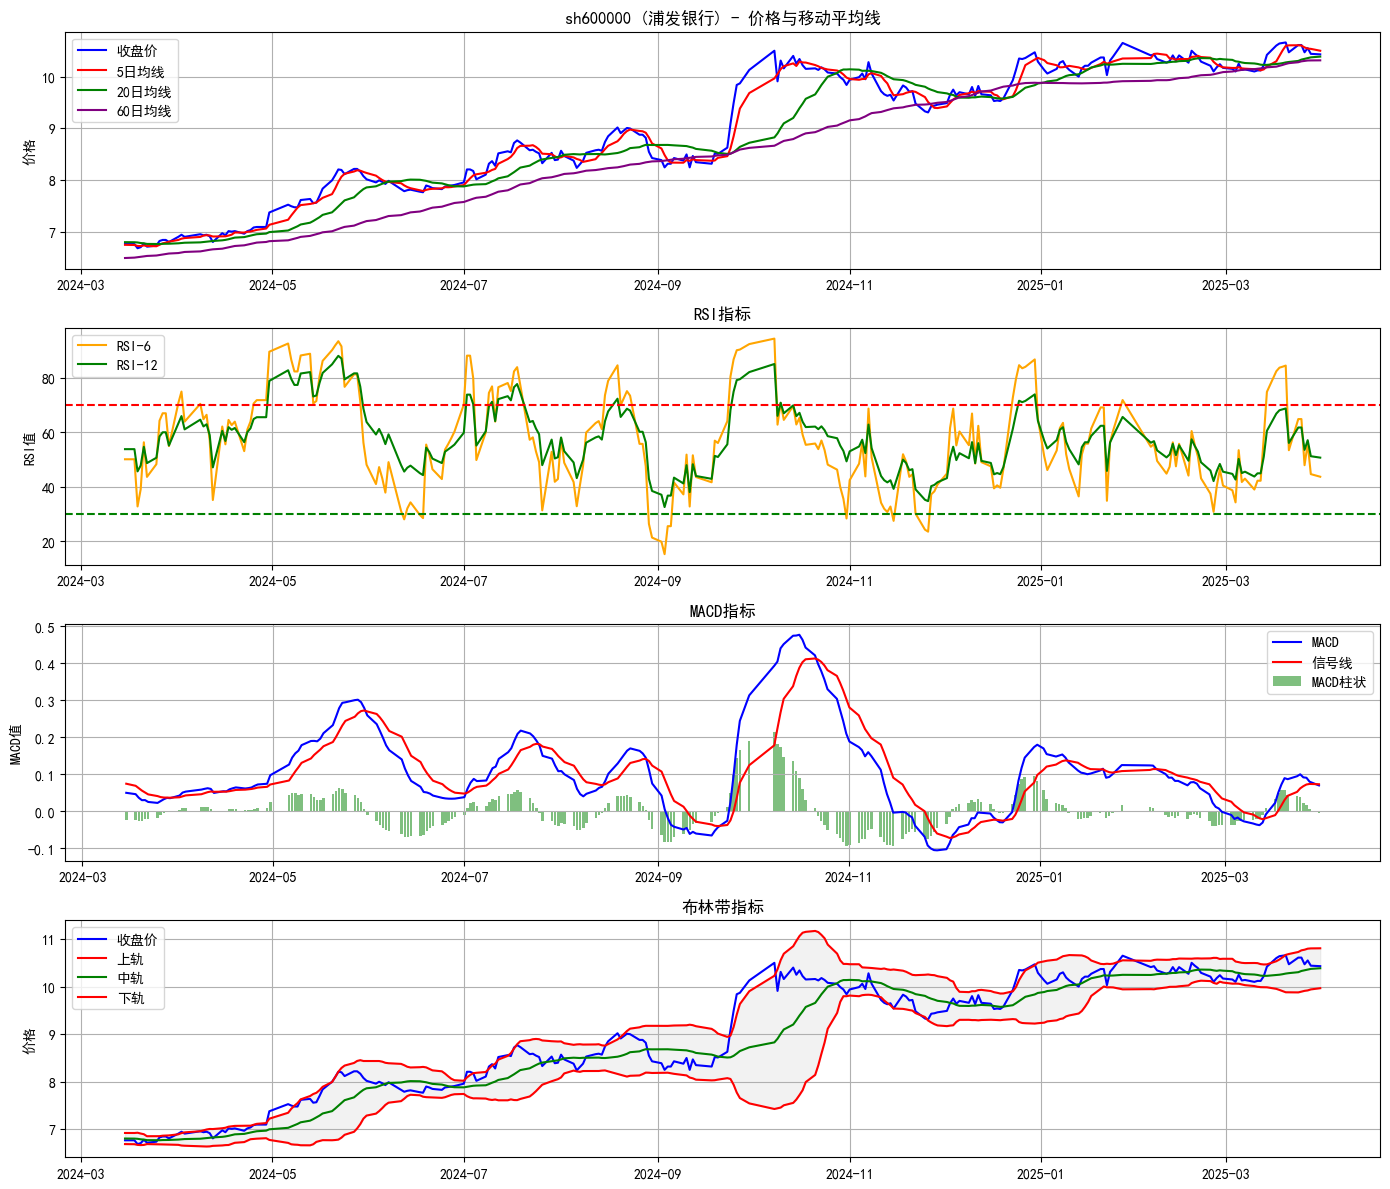

In [56]:
# 为第一只股票绘制技术指标
first_stock = list(stock_data_dict.keys())[0]
first_stock_name = sample_stocks[sample_stocks['formatted_code'] == first_stock]['name'].iloc[0]
# 选取最近一年的数据绘制
recent_data = stock_data_dict[first_stock].iloc[-252:]  # 约一年的交易日
plot_technical_indicators(recent_data, first_stock, title=f"{first_stock} ({first_stock_name})")

In [57]:
def calculate_garch_volatility(returns, window=252, mean_model='constant', vol_model='garch', 
                              p=1, q=1, o=0, dist='normal', scale=100, 
                              use_multiple_optimizers=True, min_obs=20):
    """
    使用GARCH模型预测波动率，增强了收敛性
    
    参数:
    returns: 收益率序列
    window: 滚动窗口大小，默认252（约一年交易日）
    mean_model: 均值模型，可选'constant'或'ar'
    vol_model: 波动率模型，可选'garch'或'egarch'
    p: GARCH项阶数
    q: ARCH项阶数
    o: 非对称项阶数(仅用于EGARCH)
    dist: 残差分布假设，默认'normal'，可选't'或'skewt'
    scale: 数据缩放因子，解决优化器收敛问题
    use_multiple_optimizers: 是否尝试多个优化器
    min_obs: 用于备选方法的最小观测值数量
    
    返回:
    volatility: 预测的波动率序列
    """
    # 初始化结果数组
    volatility = np.zeros_like(returns) * np.nan
    
    # 至少需要window个样本才能开始预测
    if len(returns) <= window:
        print("数据量不足以进行GARCH预测")
        return volatility
    
    # 数据预处理 - 处理缺失值
    returns = returns[np.isfinite(returns)]
    
    # 定义多个优化方法尝试顺序
    optimizers = ['slsqp', 'lbfgs', 'newton']
    
    # 使用滚动窗口进行预测
    for i in range(window, len(returns)):
        # 使用过去window个观测值拟合GARCH模型
        train_returns = returns[i-window:i]
        
        # 数据缩放以改善优化收敛性
        scaled_returns = train_returns * scale
        
        success = False
        model_fit = None
        
        try:
            # 设置模型参数
            lags = 1 if mean_model == 'ar' else None
            
            # 构建模型
            if vol_model.lower() == 'egarch':
                model = arch_model(scaled_returns, mean=mean_model, lags=lags, 
                                  vol=vol_model, p=p, q=q, o=o, dist=dist,
                                  rescale=False)  # 已手动缩放
            else:
                model = arch_model(scaled_returns, mean=mean_model, lags=lags, 
                                  vol=vol_model, p=p, q=q, dist=dist,
                                  rescale=False)  # 已手动缩放
            
            # 设置优化选项
            fit_options = {
                'disp': 'off',
                'show_warning': False,
                'cov_type': 'robust',
                'options': {'maxiter': 2000}  # 通过options字典传递maxiter
            }
            
            if use_multiple_optimizers:
                # 尝试多个优化器
                for optimizer in optimizers:
                    try:
                        fit_options['method'] = optimizer
                        model_fit = model.fit(**fit_options)
                        if not np.isnan(model_fit.params).any():
                            success = True
                            break
                    except:
                        continue
            else:
                # 只使用默认优化器
                model_fit = model.fit(**fit_options)
                if not np.isnan(model_fit.params).any():
                    success = True
            
            # 如果成功，预测下一期的波动率
            if success and model_fit is not None:
                forecast = model_fit.forecast(horizon=1)
                volatility[i] = np.sqrt(forecast.variance.iloc[-1].values[0]) / scale
            else:
                raise ValueError("模型拟合未成功")
                
        except Exception as e:
            # 如果模型拟合失败，使用历史波动率或EWMA作为备选
            # 使用最近的观测值避免使用过多过时数据
            recent_returns = train_returns[-min(len(train_returns), min_obs*5):]
            
            # 方法1: 简单历史波动率
            volatility[i] = np.std(recent_returns)
    
    return volatility

In [58]:
# 对每只股票计算GARCH和EGARCH波动率预测
for stock_code in stock_data_dict.keys():
    print(f"为 {stock_code} 计算波动率预测...")
    df = stock_data_dict[stock_code]
    
    # 确保数据足够
    if len(df) > 252:
        # 使用对数收益率进行计算
        log_returns = df['log_ret_1d'].dropna().values
        
        try:
            # 计算标准GARCH(1,1)波动率 - 使用学生t分布可能更适合金融数据
            garch_vol = calculate_garch_volatility(
                log_returns, 
                window=252,
                mean_model='constant', 
                vol_model='garch', 
                p=1, 
                q=1, 
                dist='t',  # 使用t分布
                scale=100,
                use_multiple_optimizers=True  # 尝试多个优化器
            )
            df['garch_volatility'] = garch_vol
            
            # 计算EGARCH(1,1,1)波动率
            egarch_vol = calculate_garch_volatility(
                log_returns, 
                window=252,
                mean_model='constant', 
                vol_model='egarch', 
                p=1, 
                q=1, 
                o=1,
                dist='t',  # 使用t分布
                scale=100,
                use_multiple_optimizers=True
            )
            df['egarch_volatility'] = egarch_vol
            
            print(f"{stock_code} 波动率计算完成 - GARCH和EGARCH模型")
        except Exception as e:
            print(f"{stock_code} 波动率计算出错: {str(e)}")
            # 如果整个过程失败，可以使用简单方法计算波动率
            df['simple_volatility'] = df['log_ret_1d'].rolling(20).std() * np.sqrt(252)
            print(f"{stock_code} 使用简单波动率计算替代")
        
        # 保存回字典
        stock_data_dict[stock_code] = df
    else:
        print(f"{stock_code} 数据量不足，需要至少252个交易日")

为 sh600000 计算波动率预测...
sh600000 波动率计算完成 - GARCH和EGARCH模型
为 sh600009 计算波动率预测...
sh600009 波动率计算完成 - GARCH和EGARCH模型
为 sh600010 计算波动率预测...
sh600010 波动率计算完成 - GARCH和EGARCH模型
为 sh600011 计算波动率预测...
sh600011 波动率计算完成 - GARCH和EGARCH模型
为 sh600015 计算波动率预测...
sh600015 波动率计算完成 - GARCH和EGARCH模型
为 sh600016 计算波动率预测...
sh600016 波动率计算完成 - GARCH和EGARCH模型
为 sh600018 计算波动率预测...
sh600018 波动率计算完成 - GARCH和EGARCH模型
为 sh600019 计算波动率预测...
sh600019 波动率计算完成 - GARCH和EGARCH模型
为 sh600026 计算波动率预测...
sh600026 波动率计算完成 - GARCH和EGARCH模型
为 sh600027 计算波动率预测...
sh600027 波动率计算完成 - GARCH和EGARCH模型
为 sh600028 计算波动率预测...
sh600028 波动率计算完成 - GARCH和EGARCH模型
为 sh600029 计算波动率预测...
sh600029 波动率计算完成 - GARCH和EGARCH模型
为 sh600030 计算波动率预测...
sh600030 波动率计算完成 - GARCH和EGARCH模型
为 sh600031 计算波动率预测...
sh600031 波动率计算完成 - GARCH和EGARCH模型
为 sh600036 计算波动率预测...
sh600036 波动率计算完成 - GARCH和EGARCH模型
为 sh600039 计算波动率预测...
sh600039 波动率计算完成 - GARCH和EGARCH模型
为 sh600048 计算波动率预测...
sh600048 波动率计算完成 - GARCH和EGARCH模型
为 sh600050 计算波动率预测...
sh600050 波动率计算完成 - GARCH和E

## 四、特征选择

In [59]:
# 合并特征，并准备用于机器学习的数据集
def prepare_ml_dataset(stock_data_dict, target_days=5):
    """
    准备机器学习数据集
    
    参数:
    stock_data_dict: 包含多只股票数据的字典
    target_days: 预测未来几天的收益率
    
    返回:
    X: 特征矩阵
    y: 目标变量 (未来n天收益率)
    """
    all_features = []
    all_targets = []
    all_stocks = []
    all_dates = []
    
    for stock_code, df in stock_data_dict.items():
        # 清理数据：删除包含NaN的行
        cleaned_df = df.dropna()
        
        if len(cleaned_df) == 0:
            print(f"{stock_code} 清理后没有数据，跳过")
            continue
        
        print(f"处理 {stock_code} 数据, 可用行数: {len(cleaned_df)}")
        
        # 计算目标变量: 未来n天的对数收益率
        target_col = f'future_{target_days}d_log_ret'
        cleaned_df[target_col] = cleaned_df['log_ret_1d'].rolling(window=target_days).sum().shift(-target_days)
        
        # 再次清理NaN (由于目标变量的计算)
        cleaned_df = cleaned_df.dropna(subset=[target_col])
        
        if len(cleaned_df) == 0:
            print(f"{stock_code} 计算目标变量后没有数据，跳过")
            continue
        
        # 选择特征
        feature_columns = [
            # 价格动量特征
            'ret_1d', 'ret_5d', 'ret_10d', 'ret_20d',
            
            # 技术指标
            'RSI6', 'RSI12', 'RSI24', 
            'MACD', 'MACD_SIGNAL', 'MACD_HIST',
            'BB_WIDTH', 'ATR', 'CCI',
            
            # 价格与均线关系
            'SMA5', 'SMA10', 'SMA20', 'SMA60',
            'EMA5', 'EMA10', 'EMA20',
            
            # 动量指标
            'MOM5', 'MOM10', 'MOM20',
            
            # 波动率特征
            'volatility_20d', 'garch_volatility', 'egarch_volatility',
            
            # 交易量特征
            'volume', 'amount', 'turnover',
            
            # 市场微观结构
            'amplitude', 'illiquidity',
            
            # 涨跌停标记
            'is_limit_up', 'is_limit_down'
        ]
        
        # 检查所有特征是否在DataFrame中
        available_features = [f for f in feature_columns if f in cleaned_df.columns]
        
        # 如果缺少某些特征，报告一下
        if len(available_features) < len(feature_columns):
            missing = set(feature_columns) - set(available_features)
            print(f"{stock_code} 缺少以下特征: {missing}")
        
        # 添加到总数据集
        X = cleaned_df[available_features].values
        y = cleaned_df[target_col].values
        
        all_features.append(X)
        all_targets.append(y)
        
        # 记录股票代码和日期以便后续分析
        stock_array = np.array([stock_code] * len(cleaned_df))
        date_array = np.array(cleaned_df.index)
        
        all_stocks.append(stock_array)
        all_dates.append(date_array)
    
    # 合并所有股票的数据
    if all_features:
        X = np.vstack(all_features)
        y = np.concatenate(all_targets)
        stocks = np.concatenate(all_stocks)
        dates = np.concatenate(all_dates)
        
        print(f"合并后的数据集大小: {X.shape}")
        
        # 创建特征名称列表（用于后续特征重要性分析）
        feature_names = [f for f in feature_columns if f in available_features]
        
        return X, y, stocks, dates, feature_names
    else:
        print("没有足够的数据来准备机器学习数据集")
        return None, None, None, None, None

In [60]:
# 准备预测5天收益率的数据集
X, y, stocks, dates, feature_names = prepare_ml_dataset(stock_data_dict, target_days=5)

处理 sh600000 数据, 可用行数: 3341
处理 sh600009 数据, 可用行数: 3374
处理 sh600010 数据, 可用行数: 3314
处理 sh600011 数据, 可用行数: 3374
处理 sh600015 数据, 可用行数: 3369
处理 sh600016 数据, 可用行数: 3379
处理 sh600018 数据, 可用行数: 3328
处理 sh600019 数据, 可用行数: 3288
处理 sh600026 数据, 可用行数: 3281
处理 sh600027 数据, 可用行数: 3363
处理 sh600028 数据, 可用行数: 3383
处理 sh600029 数据, 可用行数: 3364
处理 sh600030 数据, 可用行数: 3348
处理 sh600031 数据, 可用行数: 3375
处理 sh600036 数据, 可用行数: 3358
处理 sh600039 数据, 可用行数: 3297
处理 sh600048 数据, 可用行数: 3359
处理 sh600050 数据, 可用行数: 3289
处理 sh600061 数据, 可用行数: 3254
处理 sh600066 数据, 可用行数: 3338
处理 sh600085 数据, 可用行数: 3384
处理 sh600089 数据, 可用行数: 3359
处理 sh600104 数据, 可用行数: 3319
处理 sh600111 数据, 可用行数: 3381
处理 sh600115 数据, 可用行数: 3360
处理 sh600150 数据, 可用行数: 3236
处理 sh600160 数据, 可用行数: 3340
处理 sh600161 数据, 可用行数: 3260
处理 sh600176 数据, 可用行数: 3323
处理 sh600183 数据, 可用行数: 3367
处理 sh600188 数据, 可用行数: 3354
处理 sh600196 数据, 可用行数: 3360
处理 sh600219 数据, 可用行数: 3272
处理 sh600233 数据, 可用行数: 3287
处理 sh600276 数据, 可用行数: 3381
处理 sh600309 数据, 可用行数: 3243
处理 sh600332 数据, 可用行数: 3199
处

In [62]:
# 1. 检查并处理数据中的无穷大和NaN值
X_clean = X.copy()

# 将无穷大值替换为NaN
X_clean = np.where(np.isinf(X_clean), np.nan, X_clean)

# 查看是否有NaN值
nan_mask = np.isnan(X_clean)
if np.any(nan_mask):
    # 选项1: 用列的均值填充NaN值
    if isinstance(X_clean, np.ndarray):
        col_mean = np.nanmean(X_clean, axis=0)
        for col_idx in range(X_clean.shape[1]):
            col_nan_mask = nan_mask[:, col_idx]
            X_clean[col_nan_mask, col_idx] = col_mean[col_idx]
    else:  # pandas DataFrame
        X_clean = X_clean.fillna(X_clean.mean())

# 应用标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [63]:
def select_features_lasso(X, y, feature_names, alphas=None):
    """
    使用网格搜索和交叉验证的LASSO回归进行特征选择
    
    参数:
    X: 特征矩阵
    y: 目标变量
    feature_names: 特征名称列表
    alphas: alpha值范围，默认为None（将自动生成一系列值）
    
    返回:
    selected_features: 选择的特征列表
    importance_df: 特征重要性DataFrame
    best_alpha: 最佳alpha值
    """
    from sklearn.linear_model import LassoCV
    from sklearn.model_selection import KFold
    
    # 如果没有提供alpha值，则生成一系列值
    if alphas is None:
        # 生成从很小到适中的alpha值，对数尺度
        alphas = np.logspace(-5, -1, 20)
    
    # 使用交叉验证寻找最佳alpha
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=42, n_jobs=-1)
    lasso_cv.fit(X, y)
    
    # 获取最佳alpha
    best_alpha = lasso_cv.alpha_
    print(f"最佳alpha值: {best_alpha:.6f}")
    
    # 使用最佳alpha拟合LASSO模型
    from sklearn.linear_model import Lasso
    lasso = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
    lasso.fit(X, y)
    
    # 获取特征重要性
    feature_importance = np.abs(lasso.coef_)
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance,
        'Raw_Coefficient': lasso.coef_  # 保存原始系数值，可以分析正负影响
    })
    
    # 按重要性排序
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # 计算特征重要性的阈值（可以调整此值）
    # 例如使用非零系数的平均值作为阈值
    non_zero_mean = importance_df[importance_df['Importance'] > 0]['Importance'].mean()
    threshold = non_zero_mean * 0.1  # 使用平均值的10%作为阈值
    
    # 筛选重要性大于阈值的特征
    selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
    
    print(f"LASSO选择的特征数量: {len(selected_features)}")
    print("选择的特征:")
    for i, (f, imp) in enumerate(zip(importance_df['Feature'].head(len(selected_features)), 
                                    importance_df['Importance'].head(len(selected_features)))):
        print(f"  {i+1}. {f}: {imp:.6f}")
    
    # 绘制特征重要性
    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['Feature'].head(min(30, len(feature_names))), 
             importance_df['Importance'].head(min(30, len(feature_names))))
    plt.xlabel('LASSO系数绝对值')
    plt.title(f'特征重要性-LASSO方法 (alpha={best_alpha:.6f})')
    plt.gca().invert_yaxis()  # 从上到下按重要性递减排序
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 绘制原始系数（带正负号）
    plt.figure(figsize=(12, 10))
    sorted_by_abs = importance_df.sort_values('Importance', ascending=False).head(min(30, len(feature_names)))
    colors = ['blue' if c >= 0 else 'red' for c in sorted_by_abs['Raw_Coefficient']]
    plt.barh(sorted_by_abs['Feature'], sorted_by_abs['Raw_Coefficient'], color=colors)
    plt.xlabel('LASSO原始系数值')
    plt.title(f'特征系数（正/负影响）-LASSO方法 (alpha={best_alpha:.6f})')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    return selected_features, importance_df, best_alpha

使用LASSO进行特征选择...
最佳alpha值: 0.001274
LASSO选择的特征数量: 5
选择的特征:
  1. garch_volatility: 0.008834
  2. illiquidity: 0.007632
  3. amplitude: 0.001479
  4. RSI24: 0.000984
  5. ret_20d: 0.000604


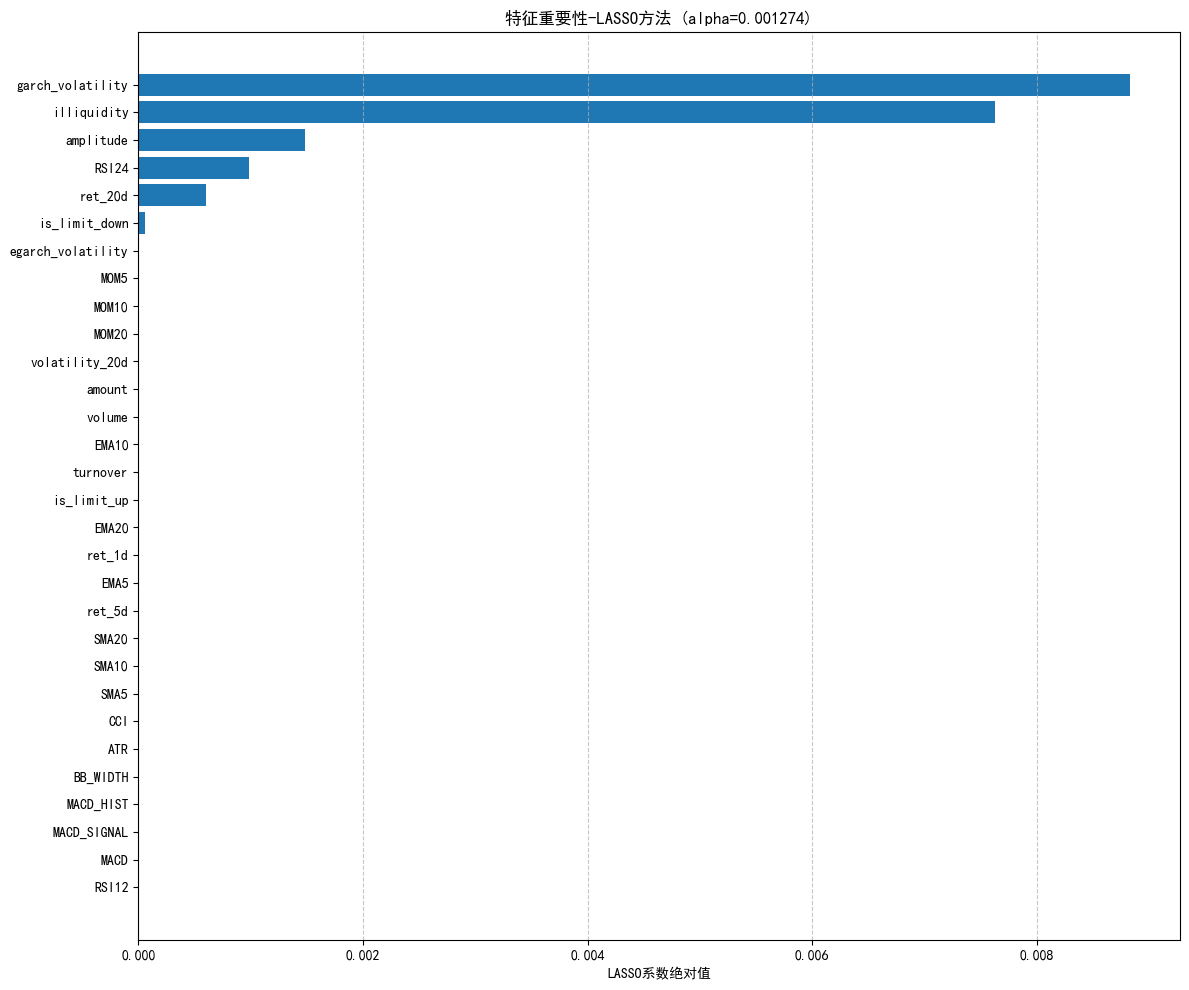

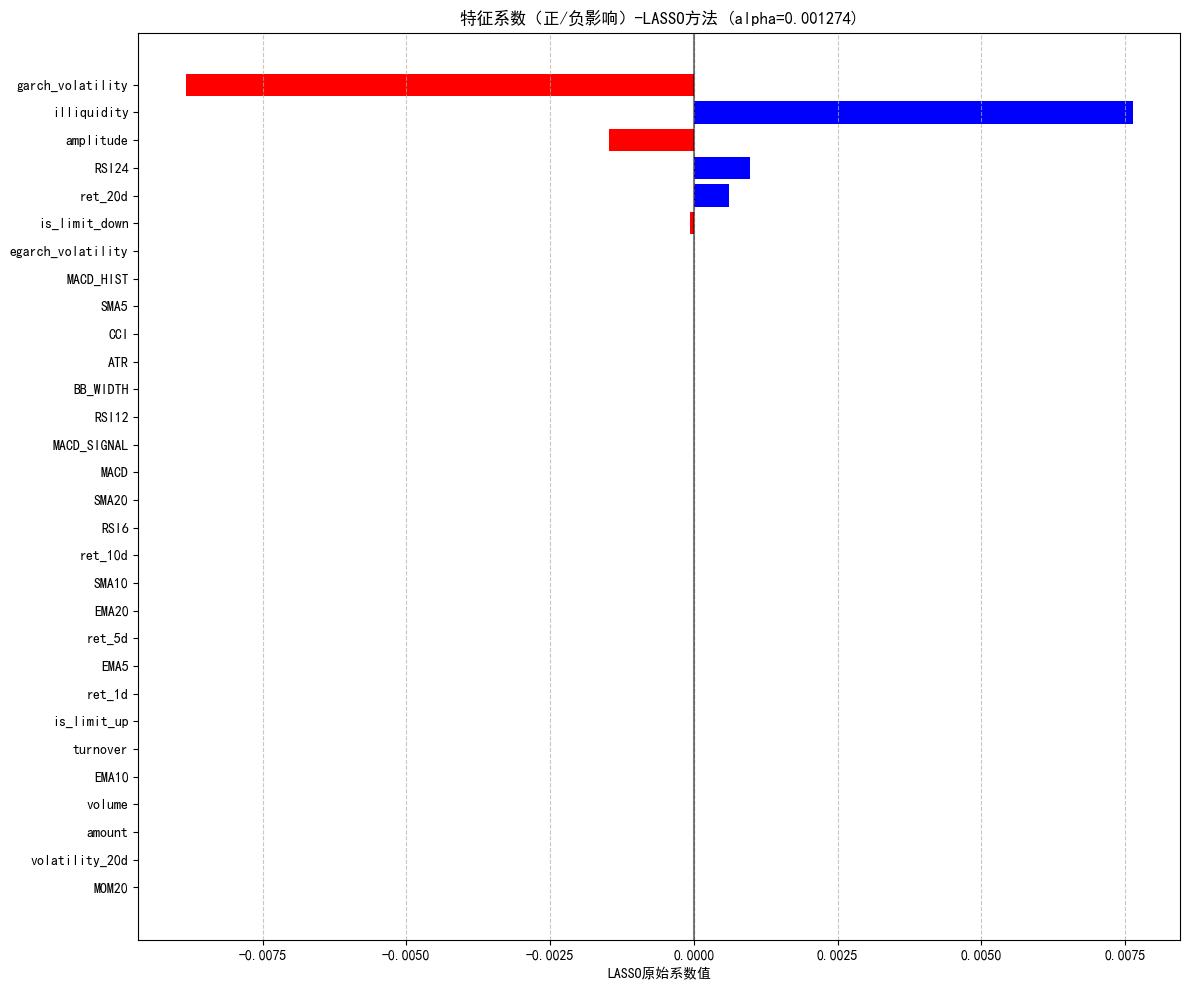

In [64]:
print("使用LASSO进行特征选择...")
lasso_selected, lasso_importance, best_alpha = select_features_lasso(
    X_scaled, y, feature_names
)

In [65]:
# 使用随机森林进行特征选择
def select_features_rf(X, y, feature_names, n_estimators=100):
    """使用随机森林进行特征选择"""
    # 拟合随机森林模型
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf.fit(X, y)
    
    # 获取特征重要性
    feature_importance = rf.feature_importances_
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # 按重要性排序
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # 绘制特征重要性
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('特征重要性')
    plt.title('特征重要性-随机森林方法')
    plt.gca().invert_yaxis()  # 从上到下按重要性递减排序
    plt.tight_layout()
    plt.show()
    
    # 选择重要性大于平均值的特征
    mean_importance = importance_df['Importance'].mean()
    selected_features = importance_df[importance_df['Importance'] > mean_importance]['Feature'].tolist()
    print(f"随机森林选择的特征数量: {len(selected_features)}")
    print("选择的特征:")
    for f in selected_features:
        print(f"  - {f}")
    
    return selected_features, importance_df


使用随机森林进行特征选择...


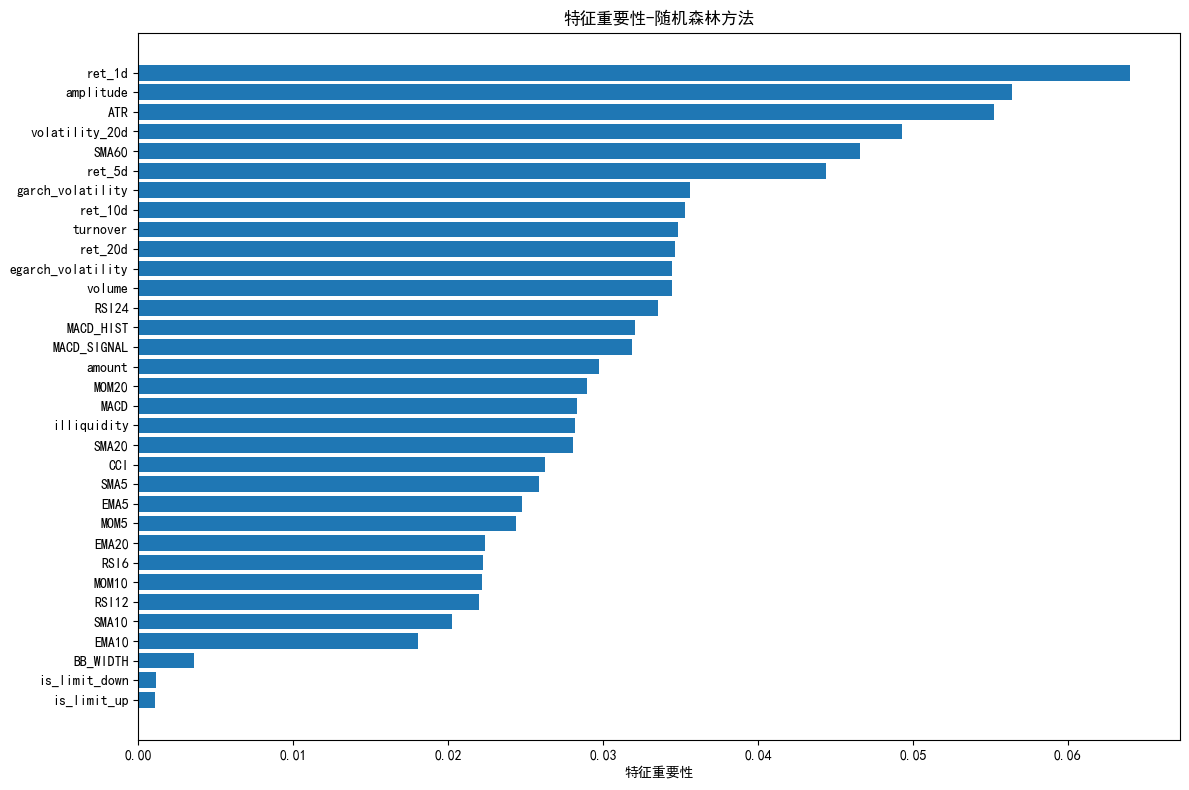

随机森林选择的特征数量: 15
选择的特征:
  - ret_1d
  - amplitude
  - ATR
  - volatility_20d
  - SMA60
  - ret_5d
  - garch_volatility
  - ret_10d
  - turnover
  - ret_20d
  - egarch_volatility
  - volume
  - RSI24
  - MACD_HIST
  - MACD_SIGNAL


In [66]:
print("\n使用随机森林进行特征选择...")
rf_selected, rf_importance = select_features_rf(X_scaled, y, feature_names, n_estimators=100)

In [67]:
# 合并两种方法选择的特征
final_selected_features = list(set(lasso_selected) | set(rf_selected))
print(f"最终选择的特征数量: {len(final_selected_features)}")
print("最终选择的特征:")
for f in final_selected_features:
    print(f"  - {f}")

最终选择的特征数量: 16
最终选择的特征:
  - RSI24
  - ret_5d
  - illiquidity
  - amplitude
  - ret_10d
  - ATR
  - turnover
  - volume
  - ret_20d
  - volatility_20d
  - garch_volatility
  - ret_1d
  - egarch_volatility
  - MACD_HIST
  - SMA60
  - MACD_SIGNAL


In [68]:
# 使用最终选择的特征构建数据集
def get_selected_features_indices(feature_names, selected_features):
    """获取选定特征的索引"""
    indices = []
    for feature in selected_features:
        if feature in feature_names:
            indices.append(feature_names.index(feature))
    return indices

In [69]:
selected_indices = get_selected_features_indices(feature_names, final_selected_features)
X_selected = X_scaled[:, selected_indices]
print(f"选择特征后的数据集大小: {X_selected.shape}")

选择特征后的数据集大小: (267393, 16)


## 五、深度学习模型开发

使用PyTorch构建LSTM和CNN-LSTM混合模型进行股票收益率预测

In [70]:
# 数据准备 - 时间序列数据
def create_sequences(X, y, seq_length=20):
    """创建时间序列序列用于LSTM"""
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

In [71]:
def train_val_test_split(X, y, dates, train_end_date='2020-12-31', val_end_date='2022-12-31'):
    """按时间划分训练集、验证集和测试集"""
    train_idx = dates <= np.datetime64(train_end_date)
    val_idx = (dates > np.datetime64(train_end_date)) & (dates <= np.datetime64(val_end_date))
    test_idx = dates > np.datetime64(val_end_date)
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    print(f"训练集大小: {X_train.shape}")
    print(f"验证集大小: {X_val.shape}")
    print(f"测试集大小: {X_test.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [86]:
# 划分数据集
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X_selected, y, dates, train_end_date='2020-12-31', val_end_date='2023-12-31')

训练集大小: (184994, 16)
验证集大小: (58813, 16)
测试集大小: (23586, 16)


In [87]:
# 创建序列
seq_length = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

print("序列数据形状:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

序列数据形状:
X_train_seq: (184974, 20, 16), y_train_seq: (184974,)
X_val_seq: (58793, 20, 16), y_val_seq: (58793,)
X_test_seq: (23566, 20, 16), y_test_seq: (23566,)


In [88]:
# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

In [89]:
# 创建数据加载器
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, 
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # LSTM前向传播
        lstm_out, _ = self.lstm(x)
        
        # 只取序列的最后一个时间步的输出
        out = lstm_out[:, -1, :]
        
        # Dropout
        out = self.dropout(out)
        
        # 全连接层
        out = self.fc(out)
        
        return out.squeeze()

In [91]:
# CNN-LSTM混合模型定义
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(CNNLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 1D卷积层用于特征提取
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        
        # LSTM层
        self.lstm = nn.LSTM(
            64, hidden_dim, num_layers=num_layers, 
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # 调整维度顺序以适应CNN (batch, seq_len, features) -> (batch, features, seq_len)
        x_conv = x.permute(0, 2, 1)
        
        # 通过CNN层
        x_conv = F.relu(self.conv1(x_conv))
        x_conv = F.relu(self.conv2(x_conv))
        
        # 调整回LSTM所需的维度顺序 (batch, features, seq_len) -> (batch, seq_len, features)
        x_lstm = x_conv.permute(0, 2, 1)
        
        # LSTM前向传播
        lstm_out, _ = self.lstm(x_lstm)
        
        # 只取序列的最后一个时间步的输出
        out = lstm_out[:, -1, :]
        
        # Dropout
        out = self.dropout(out)
        
        # 全连接层
        out = self.fc(out)
        
        return out.squeeze()

In [92]:
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001, patience=10):
    """训练深度学习模型"""
    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 损失函数
    criterion = nn.MSELoss()
    
    # 早停
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    # 训练历史
    train_losses = []
    val_losses = []
    
    # 训练循环
    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_loss = 0
        
        # 训练批次循环
        for X_batch, y_batch in train_loader:
            # 前向传播
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 计算平均训练损失
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证模式
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        # 计算平均验证损失
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # 打印训练进度
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # 加载最佳模型
    model.load_state_dict(best_model)
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, train_losses, val_losses

In [93]:
def evaluate_model(model, data_loader, criterion=nn.MSELoss()):
    """评估模型性能"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            
            all_preds.extend(y_pred.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    # 计算平均损失
    avg_loss = total_loss / len(data_loader)
    
    # 计算其他评估指标
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    
    # 计算方向准确率 (预测涨跌方向是否正确)
    direction_accuracy = np.mean((np.array(all_preds) > 0) == (np.array(all_targets) > 0))
    
    print(f'Test Loss: {avg_loss:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'R²: {r2:.6f}')
    print(f'Direction Accuracy: {direction_accuracy:.6f}')
    
    # 绘制预测vs实际值
    plt.figure(figsize=(10, 6))
    plt.scatter(all_targets, all_preds, alpha=0.3)
    plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Predicted vs Actual Returns')
    plt.grid(True)
    plt.show()
    
    return {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'direction_accuracy': direction_accuracy,
        'predictions': np.array(all_preds),
        'targets': np.array(all_targets)
    }

训练LSTM模型...
Epoch 1/50, Train Loss: 0.099005, Val Loss: 0.008763
Epoch 2/50, Train Loss: 0.098324, Val Loss: 0.008748
Epoch 3/50, Train Loss: 0.096544, Val Loss: 0.008925
Epoch 4/50, Train Loss: 0.093460, Val Loss: 0.008365
Epoch 5/50, Train Loss: 0.087471, Val Loss: 0.009383
Epoch 6/50, Train Loss: 0.082856, Val Loss: 0.008222
Epoch 7/50, Train Loss: 0.077575, Val Loss: 0.007620
Epoch 8/50, Train Loss: 0.074228, Val Loss: 0.008199
Epoch 9/50, Train Loss: 0.070090, Val Loss: 0.008016
Epoch 10/50, Train Loss: 0.066974, Val Loss: 0.008188
Epoch 11/50, Train Loss: 0.063390, Val Loss: 0.007721
Epoch 12/50, Train Loss: 0.061974, Val Loss: 0.007786
Epoch 13/50, Train Loss: 0.058370, Val Loss: 0.007801
Epoch 14/50, Train Loss: 0.057613, Val Loss: 0.007936
Epoch 15/50, Train Loss: 0.055668, Val Loss: 0.007850
Epoch 16/50, Train Loss: 0.054755, Val Loss: 0.007568
Epoch 17/50, Train Loss: 0.052711, Val Loss: 0.007884
Epoch 18/50, Train Loss: 0.051021, Val Loss: 0.007641
Epoch 19/50, Train Loss: 

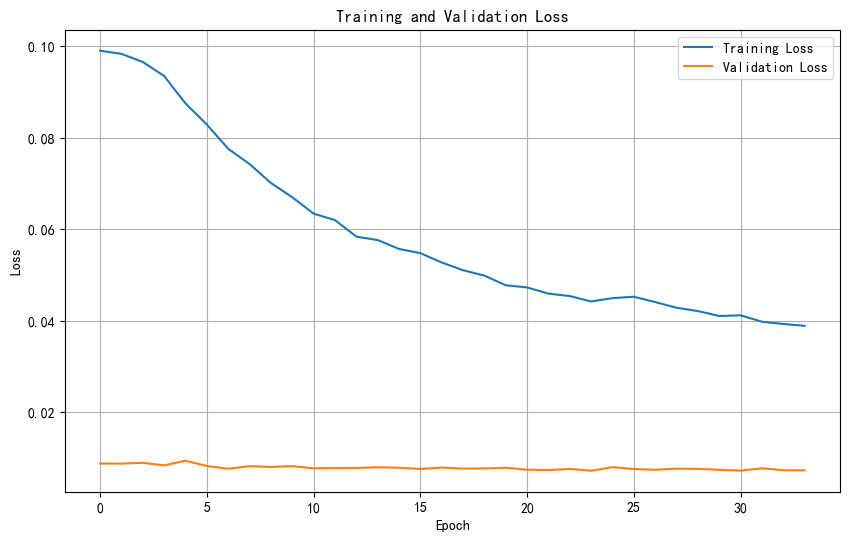

In [94]:
# 训练LSTM模型
input_dim = X_train_seq.shape[2]  # 特征维度
lstm_model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=2, dropout=0.3)
print("训练LSTM模型...")
lstm_model, lstm_train_losses, lstm_val_losses = train_model(
    lstm_model, train_loader, val_loader, epochs=50, learning_rate=0.001, patience=10)


LSTM模型评估结果:
Test Loss: 0.002293
MSE: 0.002297
RMSE: 0.047926
R²: -0.002564
Direction Accuracy: 0.511245


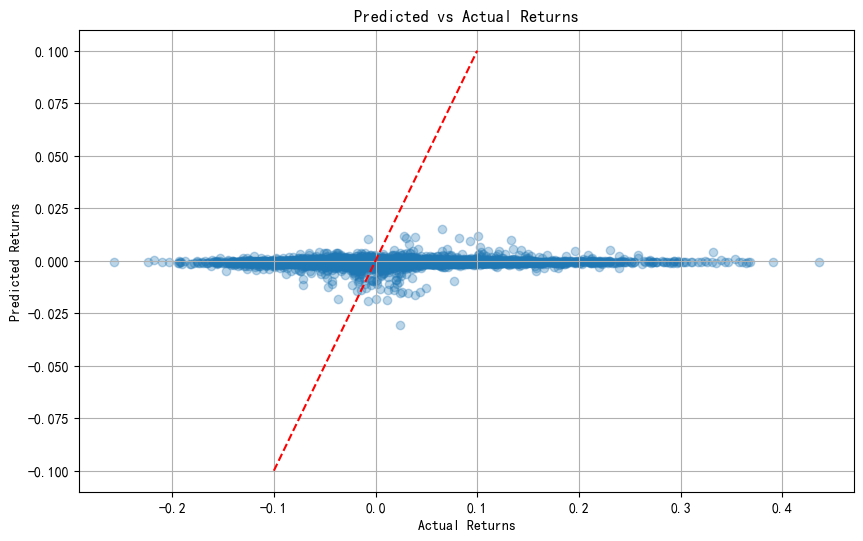

In [95]:
print("\nLSTM模型评估结果:")
lstm_results = evaluate_model(lstm_model, test_loader)

训练CNN-LSTM混合模型...
Epoch 1/50, Train Loss: 0.099177, Val Loss: 0.008804
Epoch 2/50, Train Loss: 0.098846, Val Loss: 0.008674
Epoch 3/50, Train Loss: 0.098658, Val Loss: 0.008462
Epoch 4/50, Train Loss: 0.098018, Val Loss: 0.008717
Epoch 5/50, Train Loss: 0.096902, Val Loss: 0.008556
Epoch 6/50, Train Loss: 0.095593, Val Loss: 0.008787
Epoch 7/50, Train Loss: 0.093460, Val Loss: 0.008606
Epoch 8/50, Train Loss: 0.091167, Val Loss: 0.008759
Epoch 9/50, Train Loss: 0.087874, Val Loss: 0.008740
Epoch 10/50, Train Loss: 0.084676, Val Loss: 0.008771
Epoch 11/50, Train Loss: 0.083023, Val Loss: 0.008595
Epoch 12/50, Train Loss: 0.081181, Val Loss: 0.008563
Epoch 13/50, Train Loss: 0.078711, Val Loss: 0.008552
Early stopping at epoch 13


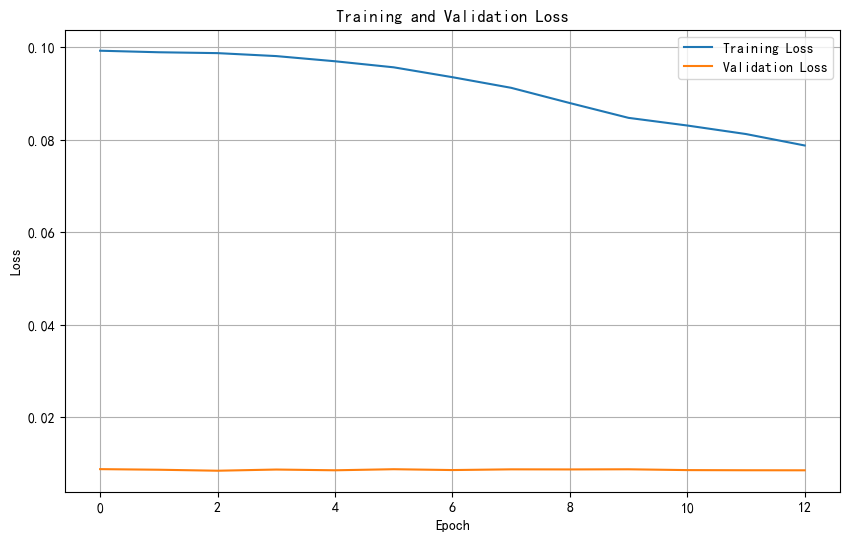

In [96]:
# 训练CNN-LSTM混合模型
cnn_lstm_model = CNNLSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=2, dropout=0.3)
print("训练CNN-LSTM混合模型...")
cnn_lstm_model, cnn_lstm_train_losses, cnn_lstm_val_losses = train_model(
    cnn_lstm_model, train_loader, val_loader, epochs=50, learning_rate=0.001, patience=10)



CNN-LSTM混合模型评估结果:
Test Loss: 0.002285
MSE: 0.002289
RMSE: 0.047848
R²: 0.000711
Direction Accuracy: 0.491301


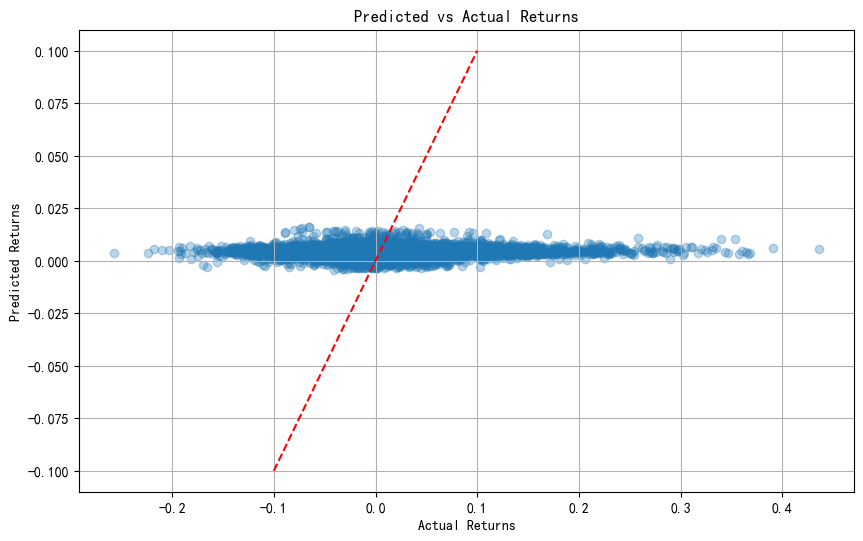

In [97]:
print("\nCNN-LSTM混合模型评估结果:")
cnn_lstm_results = evaluate_model(cnn_lstm_model, test_loader)

In [98]:
# 比较模型性能
models_comparison = pd.DataFrame({
    'LSTM': [lstm_results['mse'], lstm_results['rmse'], lstm_results['r2'], lstm_results['direction_accuracy']],
    'CNN-LSTM': [cnn_lstm_results['mse'], cnn_lstm_results['rmse'], cnn_lstm_results['r2'], cnn_lstm_results['direction_accuracy']]
}, index=['MSE', 'RMSE', 'R^2', 'Direction Accuracy'])

print("模型性能比较:")
print(models_comparison)

模型性能比较:
                        LSTM  CNN-LSTM
MSE                 0.002297  0.002289
RMSE                0.047926  0.047848
R^2                -0.002564  0.000711
Direction Accuracy  0.511245  0.491301


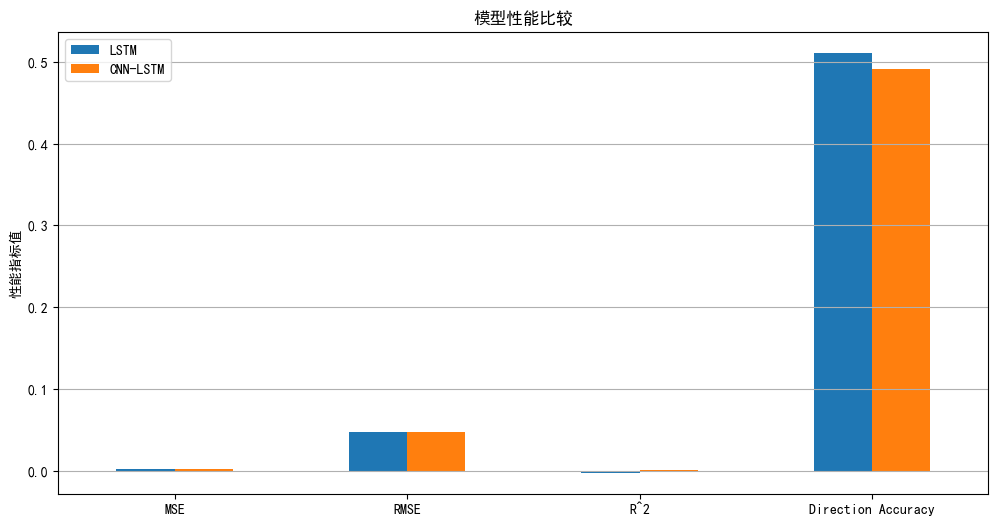

In [99]:
# 可视化比较
plt.figure(figsize=(12, 6))
models_comparison.plot(kind='bar', ax=plt.gca())
plt.title('模型性能比较')
plt.ylabel('性能指标值')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## 六、强化学习模型开发

使用强化学习进行资产配置决策，结合行为金融学的前景理论。

In [115]:
class MultiAssetTradingEnv:
    def __init__(self, prices_dict, features_dict, window_size=20, max_position=1.0, 
                 transaction_cost=0.001, reward_function='normal', loss_aversion=2.25, 
                 reference_point=0.0):
        """
        多资产交易环境
        
        参数:
        prices_dict: 字典，键为资产名称，值为价格序列
        features_dict: 字典，键为资产名称，值为输入特征矩阵
        window_size: 观察窗口大小
        max_position: 每个资产的最大持仓比例
        transaction_cost: 交易成本
        reward_function: 奖励函数类型 ('normal'标准奖励或'prospect'前景理论奖励)
        loss_aversion: 损失厌恶系数
        reference_point: 参考点
        """
        # 验证输入数据
        if not prices_dict or not features_dict:
            raise ValueError("价格字典和特征字典不能为空")
        
        # 确保价格和特征字典的键一致
        if set(prices_dict.keys()) != set(features_dict.keys()):
            # 只保留两个字典中都有的资产
            common_assets = set(prices_dict.keys()).intersection(set(features_dict.keys()))
            if not common_assets:
                raise ValueError("价格字典和特征字典没有共同的资产")
            
            # 过滤只保留共同资产
            prices_dict = {asset: prices_dict[asset] for asset in common_assets}
            features_dict = {asset: features_dict[asset] for asset in common_assets}
            print(f"警告: 只使用两个字典中都存在的资产，共 {len(common_assets)} 个")
        
        self.prices_dict = prices_dict
        self.features_dict = features_dict
        self.assets = list(prices_dict.keys())
        self.num_assets = len(self.assets)
        self.window_size = window_size
        self.max_position = max_position
        self.transaction_cost = transaction_cost
        self.reward_function = reward_function
        self.loss_aversion = loss_aversion
        self.reference_point = reference_point
        
        # 确保所有资产的时间长度相同
        self.check_data_consistency()
        
        # 找出所有资产的最短数据长度
        self.min_length = min([len(prices) for prices in self.prices_dict.values()])
        
        # 确保数据长度足够
        if self.min_length <= self.window_size:
            raise ValueError(f"数据长度 ({self.min_length}) 必须大于窗口大小 ({self.window_size})")
        
        # 状态空间和动作空间
        # 每个资产有 买入/持有/卖出 三种操作
        self.feature_dim = next(iter(self.features_dict.values())).shape[1]
        self.action_space = 3 * self.num_assets  # 每个资产有买入(0), 持有(1), 卖出(2)三种操作
        
        # 重置环境
        self.reset()
    
    def check_data_consistency(self):
        """检查数据一致性"""
        inconsistent_assets = []
        
        for asset in self.assets:
            if len(self.prices_dict[asset]) != len(self.features_dict[asset]):
                inconsistent_assets.append((asset, len(self.prices_dict[asset]), len(self.features_dict[asset])))
        
        if inconsistent_assets:
            print("警告: 以下资产的价格和特征长度不匹配:")
            for asset, price_len, feature_len in inconsistent_assets:
                print(f"  - {asset}: 价格长度={price_len}, 特征长度={feature_len}")
                
            # 修复不一致的数据
            for asset, price_len, feature_len in inconsistent_assets:
                min_len = min(price_len, feature_len)
                self.prices_dict[asset] = self.prices_dict[asset][:min_len]
                self.features_dict[asset] = self.features_dict[asset][:min_len]
                print(f"  已将 {asset} 的数据长度截断为 {min_len}")
                
            print("数据长度已调整一致")
    
    def reset(self):
        """重置环境到初始状态"""
        self.current_step = self.window_size
        
        # 初始化持仓（对每个资产）
        self.positions = {asset: 0.0 for asset in self.assets}  # 初始无持仓
        
        # 初始化现金和总资产
        self.cash = 1.0  # 初始资金标准化为1
        self.portfolio_value = self.cash
        self.portfolio_values = [self.portfolio_value]
        self.rewards = []
        self.trades = []
        
        return self._get_observation()
    
    def _get_observation(self):
        """获取当前状态观察"""
        observation = {}
        
        # 对每个资产获取特征窗口
        for asset in self.assets:
            features_window = self.features_dict[asset][self.current_step - self.window_size:self.current_step]
            observation[asset] = {
                'features': features_window,
                'position': np.array([self.positions[asset]])
            }
        
        # 添加现金信息
        observation['cash'] = np.array([self.cash])
        
        return observation
    
    def _calculate_reward(self, return_pct):
        """计算奖励"""
        if self.reward_function == 'normal':
            # 标准奖励：收益率
            return return_pct
        elif self.reward_function == 'prospect':
            # 前景理论奖励
            # v(x) = x^α if x ≥ 0
            # v(x) = -λ(-x)^β if x < 0
            # 其中λ是损失厌恶系数，我们假设α=β=1简化模型
            relative_return = return_pct - self.reference_point
            if relative_return >= 0:
                return relative_return
            else:
                return self.loss_aversion * relative_return
        else:
            raise ValueError("Unsupported reward function type")
    
    def _get_asset_and_action(self, action_idx):
        """将动作索引转换为资产索引和动作类型"""
        asset_idx = action_idx // 3
        action_type = action_idx % 3  # 0: 买入, 1: 持有, 2: 卖出
        return self.assets[asset_idx], action_type
    
    def step(self, action_idx):
        """执行动作，返回下一状态、奖励和完成标志"""
        # 保存之前的资产价值
        prev_portfolio_value = self.portfolio_value
        
        # 解析动作
        asset, action_type = self._get_asset_and_action(action_idx)
        
        # 执行交易动作
        if action_type == 0:  # 买入
            if self.positions[asset] < self.max_position and self.cash > 0:
                # 计算交易量
                trade_amount = min(self.max_position - self.positions[asset], self.cash)
                # 交易成本
                cost = trade_amount * self.transaction_cost
                # 更新持仓和现金
                self.positions[asset] += trade_amount - cost
                self.cash -= trade_amount
                # 记录交易
                self.trades.append(('buy', asset, self.current_step, trade_amount - cost))
        
        elif action_type == 2:  # 卖出
            if self.positions[asset] > 0:
                # 计算交易量
                trade_amount = self.positions[asset]
                # 交易成本
                cost = trade_amount * self.transaction_cost
                # 更新持仓和现金
                self.positions[asset] = 0
                self.cash += trade_amount - cost
                # 记录交易
                self.trades.append(('sell', asset, self.current_step, trade_amount - cost))
        
        # 更新资产价值(T+1模式，在做出决策后才能体现收益)
        if self.current_step < self.min_length - 1:
            for asset in self.assets:
                if self.positions[asset] > 0:
                    price_change = (self.prices_dict[asset][self.current_step + 1] / 
                                   self.prices_dict[asset][self.current_step]) - 1
                    self.positions[asset] *= (1 + price_change)
        
        # 更新总资产价值
        self.portfolio_value = self.cash + sum(self.positions.values())
        self.portfolio_values.append(self.portfolio_value)
        
        # 计算奖励
        return_pct = (self.portfolio_value / prev_portfolio_value) - 1
        reward = self._calculate_reward(return_pct)
        self.rewards.append(reward)
        
        # 移至下一时间步
        self.current_step += 1
        
        # 检查是否结束
        done = self.current_step >= self.min_length - 1
        
        # 返回下一状态、奖励和完成标志
        return self._get_observation(), reward, done, {}
    
    def render(self):
        """可视化环境状态"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # 绘制价格走势
        steps = range(self.window_size, self.current_step + 1)
        for asset in self.assets:
            ax1.plot(steps, self.prices_dict[asset][self.window_size:self.current_step+1], 
                     label=f'{asset}价格')
        
        ax1.set_title('各资产价格走势')
        ax1.set_ylabel('价格')
        ax1.legend()
        ax1.grid(True)
        
        # 绘制资产组合价值
        ax2.plot(steps, self.portfolio_values, label='资产组合价值', color='green')
        ax2.set_title('资产组合价值')
        ax2.set_xlabel('时间步')
        ax2.set_ylabel('价值')
        ax2.grid(True)
        
        # 标记交易点
        for trade in self.trades:
            action, asset, step, amount = trade
            if step in steps:  # 只绘制可见范围内的交易
                if action == 'buy':
                    ax1.scatter(step, self.prices_dict[asset][step], 
                                color='green', marker='^', s=100)
                else:  # sell
                    ax1.scatter(step, self.prices_dict[asset][step], 
                                color='red', marker='v', s=100)
        
        plt.tight_layout()
        plt.show()

In [116]:
# 深度Q网络模型 - 适应多资产
class MultiAssetDQN(nn.Module):
    def __init__(self, feature_dim, num_assets, hidden_dim=64):
        super(MultiAssetDQN, self).__init__()
        self.num_assets = num_assets
        
        # 每个资产有一个LSTM处理特征
        self.lstm_list = nn.ModuleList([
            nn.LSTM(
                input_size=feature_dim,
                hidden_size=hidden_dim,
                num_layers=1,
                batch_first=True
            ) for _ in range(num_assets)
        ])
        
        # 合并所有资产特征的全连接层
        self.fc_combine = nn.Linear(hidden_dim * num_assets + num_assets + 1, hidden_dim * 2)  # +num_assets为位置，+1为现金
        
        # 动作价值预测层
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3 * num_assets)  # 每个资产3个动作
    
    def forward(self, features_dict, positions_dict, cash):
        # 处理每个资产的特征
        lstm_outputs = []
        
        for i, asset in enumerate(features_dict.keys()):
            # 确保输入是3D: [batch_size, seq_len, feature_dim]
            features = features_dict[asset]
            if len(features.shape) == 2:
                # 如果输入是2D [batch_size, feature_dim]，增加一个维度变成 [batch_size, 1, feature_dim]
                features = features.unsqueeze(1)
                
            lstm_out, _ = self.lstm_list[i](features)
            lstm_out = lstm_out[:, -1, :]  # 取最后一个时间步输出
            lstm_outputs.append(lstm_out)
        
        # 合并所有资产的LSTM输出
        lstm_combined = torch.cat(lstm_outputs, dim=1)
        
        # 确保持仓信息是2D: [batch_size, num_assets]
        positions = []
        for asset in positions_dict.keys():
            pos = positions_dict[asset]
            # 处理不同维度的情况
            if len(pos.shape) == 3:  # 如果是 [batch_size, 1, 1]
                pos = pos.squeeze(1)  # 变成 [batch_size, 1]
            elif len(pos.shape) == 1:  # 如果是 [batch_size]
                pos = pos.unsqueeze(1)  # 变成 [batch_size, 1]
            positions.append(pos)
        
        # 合并持仓信息
        positions_combined = torch.cat(positions, dim=1)
        
        # 确保现金是2D: [batch_size, 1]
        if len(cash.shape) == 3:  # 如果是 [batch_size, 1, 1]
            cash = cash.squeeze(1)  # 变成 [batch_size, 1]
        elif len(cash.shape) == 1:  # 如果是 [batch_size]
            cash = cash.unsqueeze(1)  # 变成 [batch_size, 1]
            
        # 合并所有特征
        combined = torch.cat((lstm_combined, positions_combined, cash), dim=1)
        
        # 通过全连接层
        x = F.relu(self.fc_combine(combined))
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        
        return q_values

In [117]:
# 经验回放存储器 - 适应多资产
class MultiAssetReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [119]:
# DQN智能体 - 适应多资产
class MultiAssetDQNAgent:
    def __init__(self, feature_dim, num_assets, hidden_dim=64, learning_rate=0.001,
                 gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_capacity=10000, batch_size=64, target_update=10):
        """
        多资产DQN智能体
        
        参数:
        feature_dim: 特征维度
        num_assets: 资产数量
        hidden_dim: 隐藏层维度
        learning_rate: 学习率
        gamma: 折扣因子
        epsilon_start: 起始探索率
        epsilon_end: 最终探索率
        epsilon_decay: 探索率衰减
        buffer_capacity: 经验回放缓冲区容量
        batch_size: 批量大小
        target_update: 目标网络更新频率
        """
        self.feature_dim = feature_dim
        self.num_assets = num_assets
        self.action_dim = 3 * num_assets  # 每个资产3个动作
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Q网络和目标网络
        self.policy_net = MultiAssetDQN(feature_dim, num_assets, hidden_dim)
        self.target_net = MultiAssetDQN(feature_dim, num_assets, hidden_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # 经验回放缓冲区
        self.replay_buffer = MultiAssetReplayBuffer(buffer_capacity)
        
        # 优化器
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # 训练步数计数器
        self.steps_done = 0
    
    def _prepare_state_input(self, state):
        """将状态转换为网络输入格式"""
        features_dict = {}
        positions_dict = {}
        
        for asset_name, asset_state in state.items():
            if asset_name != 'cash':
                # 处理特征，确保形状正确
                features = torch.FloatTensor(asset_state['features']).unsqueeze(0)
                positions = torch.FloatTensor([asset_state['position']]).unsqueeze(0)
                features_dict[asset_name] = features
                positions_dict[asset_name] = positions
        
        cash = torch.FloatTensor([state['cash']]).unsqueeze(0)
        
        return features_dict, positions_dict, cash
    
    def select_action(self, state, training=True):
        """选择动作，训练时使用ε-贪婪策略"""
        if training and random.random() < self.epsilon:
            # 探索：随机选择动作
            return random.randrange(self.action_dim)
        else:
            # 利用：选择Q值最大的动作
            with torch.no_grad():
                features_dict, positions_dict, cash = self._prepare_state_input(state)
                q_values = self.policy_net(features_dict, positions_dict, cash)
                return q_values.max(1)[1].item()
    
    def update_epsilon(self):
        """更新探索率"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def store_transition(self, state, action, reward, next_state, done):
        """存储经验"""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def _batch_states_to_tensors(self, states):
        """将批量状态转换为张量"""
        # 存储所有资产的特征和持仓
        batch_size = len(states)
        asset_names = [name for name in states[0].keys() if name != 'cash']
        
        features_batch = {}
        positions_batch = {}
        
        for asset in asset_names:
            # 收集这个资产的所有特征
            features = []
            positions = []
            
            for state in states:
                if asset in state:  # 确保状态中有该资产
                    features.append(state[asset]['features'])
                    positions.append(state[asset]['position'])
            
            # 转换为张量，确保维度正确
            features_batch[asset] = torch.FloatTensor(np.array(features))
            positions_batch[asset] = torch.FloatTensor(np.array(positions)).reshape(batch_size, 1)
        
        # 收集现金信息
        cash_batch = torch.FloatTensor([state['cash'] for state in states]).reshape(batch_size, 1)
        
        return features_batch, positions_batch, cash_batch
    
    def update(self):
        """更新网络参数"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # 从经验回放缓冲区采样
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # 转换为张量
        features_batch, positions_batch, cash_batch = self._batch_states_to_tensors(states)
        next_features_batch, next_positions_batch, next_cash_batch = self._batch_states_to_tensors(next_states)
        
        actions_batch = torch.LongTensor(actions).unsqueeze(1)
        rewards_batch = torch.FloatTensor(rewards)
        dones_batch = torch.FloatTensor(dones)
        
        # 计算当前Q值
        current_q_values = self.policy_net(features_batch, positions_batch, cash_batch).gather(1, actions_batch).squeeze(1)
        
        # 计算下一状态的最大Q值
        next_q_values = self.target_net(next_features_batch, next_positions_batch, next_cash_batch).max(1)[0].detach()
        
        # 计算目标Q值
        target_q_values = rewards_batch + (1 - dones_batch) * self.gamma * next_q_values
        
        # 计算损失
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        
        # 优化模型
        self.optimizer.zero_grad()
        loss.backward()
        # 梯度裁剪防止梯度爆炸
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # 更新目标网络
        self.steps_done += 1
        if self.steps_done % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()

In [120]:
# PPO Actor-Critic网络 - 适应多资产
class MultiAssetActorCritic(nn.Module):
    def __init__(self, feature_dim, num_assets, hidden_dim=64):
        super(MultiAssetActorCritic, self).__init__()
        self.num_assets = num_assets
        
        # 每个资产有一个LSTM处理特征
        self.lstm_list = nn.ModuleList([
            nn.LSTM(
                input_size=feature_dim,
                hidden_size=hidden_dim,
                num_layers=1,
                batch_first=True
            ) for _ in range(num_assets)
        ])
        
        # 合并所有资产特征的全连接层
        self.fc_combine = nn.Linear(hidden_dim * num_assets + num_assets + 1, hidden_dim * 2)  # +num_assets为位置，+1为现金
        
        # Actor网络 (策略网络)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3 * num_assets),  # 每个资产3个动作
            nn.Softmax(dim=-1)
        )
        
        # Critic网络 (价值网络)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, features_dict, positions_dict, cash):
        # 处理每个资产的特征
        lstm_outputs = []
        
        for i, asset in enumerate(features_dict.keys()):
            # 确保输入是3D: [batch_size, seq_len, feature_dim]
            features = features_dict[asset]
            if len(features.shape) == 2:
                # 如果输入是2D [batch_size, feature_dim]，增加一个维度变成 [batch_size, 1, feature_dim]
                features = features.unsqueeze(1)
                
            lstm_out, _ = self.lstm_list[i](features)
            lstm_out = lstm_out[:, -1, :]  # 取最后一个时间步输出
            lstm_outputs.append(lstm_out)
        
        # 合并所有资产的LSTM输出
        lstm_combined = torch.cat(lstm_outputs, dim=1)
        
        # 确保持仓信息是2D: [batch_size, num_assets]
        positions = []
        for asset in positions_dict.keys():
            pos = positions_dict[asset]
            # 处理不同维度的情况
            if len(pos.shape) == 3:  # 如果是 [batch_size, 1, 1]
                pos = pos.squeeze(1)  # 变成 [batch_size, 1]
            elif len(pos.shape) == 1:  # 如果是 [batch_size]
                pos = pos.unsqueeze(1)  # 变成 [batch_size, 1]
            positions.append(pos)
        
        # 合并持仓信息
        positions_combined = torch.cat(positions, dim=1)
        
        # 确保现金是2D: [batch_size, 1]
        if len(cash.shape) == 3:  # 如果是 [batch_size, 1, 1]
            cash = cash.squeeze(1)  # 变成 [batch_size, 1]
        elif len(cash.shape) == 1:  # 如果是 [batch_size]
            cash = cash.unsqueeze(1)  # 变成 [batch_size, 1]
            
        # 合并所有特征
        combined = torch.cat((lstm_combined, positions_combined, cash), dim=1)
        
        # 通过共享层
        x = F.relu(self.fc_combine(combined))
        
        # 计算动作概率和状态价值
        action_probs = self.actor(x)
        state_value = self.critic(x)
        
        return action_probs, state_value


In [121]:
# PPO智能体 - 适应多资产
class MultiAssetPPOAgent:
    def __init__(self, feature_dim, num_assets, hidden_dim=64, learning_rate=0.0003,
                 gamma=0.99, gae_lambda=0.95, clip_epsilon=0.2, epochs=10, batch_size=64):
        """
        多资产PPO智能体
        
        参数:
        feature_dim: 特征维度
        num_assets: 资产数量
        hidden_dim: 隐藏层维度
        learning_rate: 学习率
        gamma: 折扣因子
        gae_lambda: GAE lambda参数
        clip_epsilon: PPO裁剪参数
        epochs: 每批数据的训练回合数
        batch_size: 批量大小
        """
        self.feature_dim = feature_dim
        self.num_assets = num_assets
        self.action_dim = 3 * num_assets  # 每个资产3个动作
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_epsilon = clip_epsilon
        self.epochs = epochs
        self.batch_size = batch_size
        
        # Actor-Critic网络
        self.ac_model = MultiAssetActorCritic(feature_dim, num_assets, hidden_dim)
        
        # 优化器
        self.optimizer = optim.Adam(self.ac_model.parameters(), lr=learning_rate)
    
    def _prepare_state_input(self, state):
        """将状态转换为网络输入格式"""
        features_dict = {}
        positions_dict = {}
        
        for asset_name, asset_state in state.items():
            if asset_name != 'cash':
                # 处理特征，确保形状正确
                features = torch.FloatTensor(asset_state['features']).unsqueeze(0)
                positions = torch.FloatTensor([asset_state['position']]).unsqueeze(0)
                features_dict[asset_name] = features
                positions_dict[asset_name] = positions
        
        cash = torch.FloatTensor([state['cash']]).unsqueeze(0)
        
        return features_dict, positions_dict, cash
    
    def select_action(self, state, training=True):
        """选择动作"""
        with torch.no_grad():
            features_dict, positions_dict, cash = self._prepare_state_input(state)
            action_probs, _ = self.ac_model(features_dict, positions_dict, cash)
            
            if training:
                # 训练时从概率分布中采样
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample().item()
            else:
                # 评估时选择概率最高的动作
                action = action_probs.argmax(dim=1).item()
            
            return action, action_probs[0][action].item()
    def _batch_states_to_tensors(self, states):
        """将批量状态转换为张量"""
        # 存储所有资产的特征和持仓
        batch_size = len(states)
        asset_names = [name for name in states[0].keys() if name != 'cash']
        
        features_batch = {}
        positions_batch = {}
        
        for asset in asset_names:
            # 收集这个资产的所有特征
            features = []
            positions = []
            
            for state in states:
                if asset in state:  # 确保状态中有该资产
                    features.append(state[asset]['features'])
                    positions.append(state[asset]['position'])
            
            # 转换为张量，确保维度正确
            features_batch[asset] = torch.FloatTensor(np.array(features))
            positions_batch[asset] = torch.FloatTensor(np.array(positions)).reshape(batch_size, 1)
        
        # 收集现金信息
        cash_batch = torch.FloatTensor([state['cash'] for state in states]).reshape(batch_size, 1)
        
        return features_batch, positions_batch, cash_batch
    
    def update(self, states, actions, old_probs, rewards, next_states, dones):
        """更新网络参数"""
        # 转换为张量
        features_batch, positions_batch, cash_batch = self._batch_states_to_tensors(states)
        next_features_batch, next_positions_batch, next_cash_batch = self._batch_states_to_tensors(next_states)
        
        actions_batch = torch.LongTensor(actions)
        old_probs_batch = torch.FloatTensor(old_probs)
        rewards_batch = torch.FloatTensor(rewards)
        dones_batch = torch.FloatTensor(dones)
        
        # 计算优势函数
        with torch.no_grad():
            values = self.ac_model(features_batch, positions_batch, cash_batch)[1].squeeze()
            next_values = self.ac_model(next_features_batch, next_positions_batch, next_cash_batch)[1].squeeze()
            
            # 计算TD目标和优势
            deltas = rewards_batch + self.gamma * next_values * (1 - dones_batch) - values
            
            # 广义优势估计 (GAE)
            advantages = torch.zeros_like(deltas)
            gae = 0
            for t in reversed(range(len(deltas))):
                gae = deltas[t] + self.gamma * self.gae_lambda * (1 - dones_batch[t]) * gae
                advantages[t] = gae
            
            # 计算回报
            returns = advantages + values
            
            # 标准化优势
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # 更新策略和价值函数
        for _ in range(self.epochs):
            # 打乱数据
            indices = torch.randperm(len(features_batch[list(features_batch.keys())[0]]))
            
            # 小批量训练
            for start_idx in range(0, len(indices), self.batch_size):
                # 获取小批量索引
                idx = indices[start_idx:start_idx + self.batch_size]
                
                # 小批量数据 - 特征和持仓
                mb_features = {asset: features[idx] for asset, features in features_batch.items()}
                mb_positions = {asset: positions[idx] for asset, positions in positions_batch.items()}
                mb_cash = cash_batch[idx]
                
                mb_actions = actions_batch[idx]
                mb_old_probs = old_probs_batch[idx]
                mb_returns = returns[idx]
                mb_advantages = advantages[idx]
                
                # 前向传播
                action_probs, values = self.ac_model(mb_features, mb_positions, mb_cash)
                values = values.squeeze()
                
                # 计算新的动作概率
                dist = torch.distributions.Categorical(action_probs)
                new_probs = dist.log_prob(mb_actions).exp()
                
                # 计算比率
                ratio = new_probs / mb_old_probs
                
                # 计算裁剪目标
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * mb_advantages
                
                # 计算策略损失 (负号是因为我们要最大化这个目标)
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # 计算价值损失
                value_loss = F.mse_loss(values, mb_returns)
                
                # 计算熵 (用于鼓励探索)
                entropy = dist.entropy().mean()
                
                # 总损失
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                
                # 优化
                self.optimizer.zero_grad()
                loss.backward()
                # 梯度裁剪防止梯度爆炸
                nn.utils.clip_grad_norm_(self.ac_model.parameters(), 0.5)
                self.optimizer.step()
        
        return loss.item()

In [122]:
# 训练DQN智能体 - 多资产版本
def train_multi_asset_dqn_agent(env, agent, num_episodes=100, max_steps=1000, eval_interval=10):
    """训练多资产DQN智能体"""
    episode_rewards = []
    portfolio_values = []
    losses = []
    best_reward = -float('inf')
    
    for episode in range(num_episodes):
        # 重置环境
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        
        for step in range(max_steps):
            # 选择动作
            action = agent.select_action(state)
            
            # 执行动作
            next_state, reward, done, _ = env.step(action)
            
            # 存储经验
            agent.store_transition(state, action, reward, next_state, done)
            
            # 更新网络
            loss = agent.update()
            if loss is not None:
                episode_loss += loss
            
            # 更新状态和累积奖励
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        # 更新探索率
        agent.update_epsilon()
        
        # 记录结果
        episode_rewards.append(episode_reward)
        portfolio_values.append(env.portfolio_value)
        losses.append(episode_loss / (step + 1) if step > 0 else 0)
        
        # 评估和打印进度
        if (episode + 1) % eval_interval == 0:
            avg_reward = np.mean(episode_rewards[-eval_interval:])
            avg_portfolio = np.mean(portfolio_values[-eval_interval:])
            avg_loss = np.mean(losses[-eval_interval:])
            
            print(f"Episode {episode+1}/{num_episodes}, "
                  f"Avg Reward: {avg_reward:.6f}, "
                  f"Avg Portfolio Value: {avg_portfolio:.6f}, "
                  f"Avg Loss: {avg_loss:.6f}, "
                  f"Epsilon: {agent.epsilon:.4f}")
            
            # 保存最佳模型
            if avg_reward > best_reward:
                best_reward = avg_reward
                torch.save(agent.policy_net.state_dict(), "best_multi_asset_dqn_model.pth")
    
    # 可视化训练过程
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # 绘制累积奖励
    ax1.plot(episode_rewards)
    ax1.set_title('累积奖励')
    ax1.set_xlabel('训练回合')
    ax1.set_ylabel('奖励')
    ax1.grid(True)
    
    # 绘制资产组合价值
    ax2.plot(portfolio_values)
    ax2.set_title('资产组合价值')
    ax2.set_xlabel('训练回合')
    ax2.set_ylabel('价值')
    ax2.grid(True)
    
    # 绘制损失
    ax3.plot(losses)
    ax3.set_title('网络训练损失')
    ax3.set_xlabel('训练回合')
    ax3.set_ylabel('损失')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return episode_rewards, portfolio_values, losses

In [123]:
# 训练PPO智能体 - 多资产版本
def train_multi_asset_ppo_agent(env, agent, num_episodes=100, max_steps=1000, eval_interval=10):
    """训练多资产PPO智能体"""
    episode_rewards = []
    portfolio_values = []
    losses = []
    best_reward = -float('inf')
    
    for episode in range(num_episodes):
        # 重置环境和缓冲区
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        
        states = []
        actions = []
        action_probs = []
        rewards = []
        next_states = []
        dones = []
        
        for step in range(max_steps):
            # 选择动作
            action, action_prob = agent.select_action(state)
            
            # 执行动作
            next_state, reward, done, _ = env.step(action)
            
            # 存储经验
            states.append(state)
            actions.append(action)
            action_probs.append(action_prob)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(float(done))
            
            # 更新状态和累积奖励
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        # 更新网络
        loss = agent.update(states, actions, action_probs, rewards, next_states, dones)
        episode_loss = loss
        
        # 记录结果
        episode_rewards.append(episode_reward)
        portfolio_values.append(env.portfolio_value)
        losses.append(episode_loss)
        
        # 评估和打印进度
        if (episode + 1) % eval_interval == 0:
            avg_reward = np.mean(episode_rewards[-eval_interval:])
            avg_portfolio = np.mean(portfolio_values[-eval_interval:])
            avg_loss = np.mean(losses[-eval_interval:])
            
            print(f"Episode {episode+1}/{num_episodes}, "
                  f"Avg Reward: {avg_reward:.6f}, "
                  f"Avg Portfolio Value: {avg_portfolio:.6f}, "
                  f"Avg Loss: {avg_loss:.6f}")
            
            # 保存最佳模型
            if avg_reward > best_reward:
                best_reward = avg_reward
                torch.save(agent.ac_model.state_dict(), "best_multi_asset_ppo_model.pth")
    
    # 可视化训练过程
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # 绘制累积奖励
    ax1.plot(episode_rewards)
    ax1.set_title('累积奖励')
    ax1.set_xlabel('训练回合')
    ax1.set_ylabel('奖励')
    ax1.grid(True)
    
    # 绘制资产组合价值
    ax2.plot(portfolio_values)
    ax2.set_title('资产组合价值')
    ax2.set_xlabel('训练回合')
    ax2.set_ylabel('价值')
    ax2.grid(True)
    
    # 绘制损失
    ax3.plot(losses)
    ax3.set_title('网络训练损失')
    ax3.set_xlabel('训练回合')
    ax3.set_ylabel('损失')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return episode_rewards, portfolio_values, losses

In [124]:
def prepare_multi_asset_rl_data(stock_data_dict):
    """准备用于多资产强化学习的数据"""
    prices_dict = {}
    features_dict = {}
    
    # 选择要使用的特征
    feature_cols = [
        'ret_1d', 'ret_5d', 'ret_10d', 'volatility_20d',
        'RSI6', 'RSI12', 'MACD', 'BB_WIDTH', 'ATR',
        'SMA5', 'SMA20', 'turnover', 'illiquidity'
    ]
    
    for stock_name, stock_data in stock_data_dict.items():
        try:
            # 提取价格
            prices_dict[stock_name] = stock_data['close'].values
            
            # 选择特征
            available_features = [col for col in feature_cols if col in stock_data.columns]
            features_df = stock_data[available_features]
            
            # 处理缺失值和异常值
            features_df = features_df.replace([np.inf, -np.inf], np.nan)  # 将无穷值替换为NaN
            features_df = features_df.fillna(method='ffill')  # 用前一个值填充NaN
            features_df = features_df.fillna(method='bfill')  # 如果开头有NaN，用后一个值填充
            features_df = features_df.fillna(0)  # 如果还有NaN，用0填充
            
            # 检查是否还有异常值
            if np.any(np.isnan(features_df.values)) or np.any(np.isinf(features_df.values)):
                print(f"警告: {stock_name} 数据仍包含NaN或无穷值，将跳过此股票")
                continue
                
            features = features_df.values
            
            # 标准化特征
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(features)
            
            features_dict[stock_name] = features_scaled
            
        except Exception as e:
            print(f"处理 {stock_name} 时出错: {e}")
            continue
    
    # 确保至少有一只股票的数据
    if not prices_dict:
        raise ValueError("处理后没有可用的股票数据，请检查原始数据")
    
    print(f"成功处理的股票数量: {len(prices_dict)}")
    
    # 返回处理后的数据和特征列表
    return prices_dict, features_dict, available_features

In [125]:
# 准备多资产强化学习数据
prices_dict, features_dict, rl_feature_names = prepare_multi_asset_rl_data(stock_data_dict)

# 检查数据长度一致性
min_length = float('inf')
for stock, price_data in prices_dict.items():
    if len(price_data) < min_length:
        min_length = len(price_data)

print(f"所有股票数据的最小长度: {min_length}")

# 如果数据太短，可能无法有效训练
if min_length < 100:
    print("警告: 数据长度过短，可能影响训练效果")

num_assets = len(prices_dict)
print(f"股票数量: {num_assets}")
print(f"使用的特征: {rl_feature_names}")

成功处理的股票数量: 81
所有股票数据的最小长度: 3143
股票数量: 81
使用的特征: ['ret_1d', 'ret_5d', 'ret_10d', 'volatility_20d', 'RSI6', 'RSI12', 'MACD', 'BB_WIDTH', 'ATR', 'SMA5', 'SMA20', 'turnover', 'illiquidity']


In [126]:
#  创建多资产交易环境
window_size = 20
env = MultiAssetTradingEnv(
    prices_dict=prices_dict,
    features_dict=features_dict,
    window_size=window_size,
    max_position=1.0 / num_assets,  # 平均分配资金上限
    transaction_cost=0.001,
    reward_function='prospect',  # 使用前景理论奖励
    loss_aversion=2.25,  # 设置损失厌恶系数
    reference_point=0.0
)

# 确定特征维度
feature_dim = next(iter(features_dict.values())).shape[1]
feature_dim

13

In [127]:
# 初始化并训练DQN智能体
print("初始化多资产DQN智能体...")
dqn_agent = MultiAssetDQNAgent(
    feature_dim=feature_dim,
    num_assets=num_assets,
    hidden_dim=64,
    learning_rate=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    buffer_capacity=10000,
    batch_size=64,
    target_update=10
)

# 训练DQN智能体
print("训练多资产DQN智能体...")
dqn_rewards, dqn_portfolio_values, dqn_losses = train_multi_asset_dqn_agent(
    env=env,
    agent=dqn_agent,
    num_episodes=50,
    max_steps=env.min_length - window_size - 1,
    eval_interval=5
)

初始化多资产DQN智能体...
训练多资产DQN智能体...
Episode 5/50, Avg Reward: -8.068562, Avg Portfolio Value: 2.094748, Avg Loss: 16175.950817, Epsilon: 0.9752
Episode 10/50, Avg Reward: nan, Avg Portfolio Value: -inf, Avg Loss: nan, Epsilon: 0.9511


KeyboardInterrupt: 

In [ ]:
# 初始化并训练PPO智能体
print("初始化多资产PPO智能体...")
ppo_agent = MultiAssetPPOAgent(
    feature_dim=feature_dim,
    num_assets=num_assets,
    hidden_dim=64,
    learning_rate=0.0003,
    gamma=0.99,
    gae_lambda=0.95,
    clip_epsilon=0.2,
    epochs=10,
    batch_size=64
)

# 训练PPO智能体
print("训练多资产PPO智能体...")
ppo_rewards, ppo_portfolio_values, ppo_losses = train_multi_asset_ppo_agent(
    env=env,
    agent=ppo_agent,
    num_episodes=50,
    max_steps=env.min_length - window_size - 1,
    eval_interval=5
)

In [ ]:
# 比较DQN和PPO性能
plt.figure(figsize=(14, 7))
plt.plot(dqn_portfolio_values, label='DQN')
plt.plot(ppo_portfolio_values, label='PPO')
plt.xlabel('训练回合')
plt.ylabel('最终资产组合价值')
plt.title('DQN vs PPO: 多资产资产组合价值比较')
plt.legend()
plt.grid(True)
plt.show()

## 七、交易策略构建与回测

In [ ]:
class BacktestEngine:
    def __init__(self, prices, features, model, window_size=20, initial_capital=1000000,
                 transaction_cost=0.001, position_limit=0.1, stop_loss=0.05):
        """
        回测引擎
        
        参数:
        prices: 价格序列
        features: 特征矩阵
        model: 预测模型
        window_size: 观察窗口大小
        initial_capital: 初始资金
        transaction_cost: 交易成本
        position_limit: 单一持仓上限 (占总资产比例)
        stop_loss: 止损比例
        """
        self.prices = prices
        self.features = features
        self.model = model
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.position_limit = position_limit
        self.stop_loss = stop_loss
        
        # 初始化回测状态
        self.reset()
    
    def reset(self):
        """重置回测状态"""
        self.current_step = self.window_size
        self.cash = self.initial_capital
        self.position = 0  # 持有股票数量
        self.position_value = 0  # 持仓价值
        self.portfolio_value = self.cash
        
        # 记录交易和绩效
        self.trades = []
        self.portfolio_values = [self.portfolio_value]
        self.cash_history = [self.cash]
        self.position_history = [0]
        self.returns = []
    
    def _get_state(self):
        """获取当前状态"""
        features_window = self.features[self.current_step-self.window_size:self.current_step]
        position_pct = self.position_value / self.portfolio_value if self.portfolio_value > 0 else 0
        
        state = {
            'features': features_window,
            'position': np.array([position_pct])
        }
        
        return state
    
    def _execute_trade(self, action):
        """执行交易"""
        current_price = self.prices[self.current_step]
        
        if action == 0:  # 买入
            # 计算可买入金额 (考虑持仓上限)
            max_position_value = self.portfolio_value * self.position_limit
            buy_capacity = max_position_value - self.position_value
            
            if buy_capacity > 0 and self.cash > 0:
                # 可买入数量
                shares_to_buy = min(buy_capacity, self.cash) / current_price
                cost = shares_to_buy * current_price
                transaction_fee = cost * self.transaction_cost
                total_cost = cost + transaction_fee
                
                # 更新持仓
                if total_cost <= self.cash:
                    self.position += shares_to_buy
                    self.cash -= total_cost
                    self.position_value = self.position * current_price
                    
                    # 记录交易
                    self.trades.append({
                        'date': self.current_step,
                        'type': 'buy',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'cost': total_cost
                    })
        
        elif action == 2:  # 卖出
            if self.position > 0:
                # 全部卖出
                value = self.position * current_price
                transaction_fee = value * self.transaction_cost
                proceeds = value - transaction_fee
                
                # 更新持仓
                self.cash += proceeds
                self.position = 0
                self.position_value = 0
                
                # 记录交易
                self.trades.append({
                    'date': self.current_step,
                    'type': 'sell',
                    'price': current_price,
                    'shares': self.position,
                    'proceeds': proceeds
                })
    
    def _check_stop_loss(self):
        """检查止损条件"""
        if self.position > 0:
            current_price = self.prices[self.current_step]
            position_value = self.position * current_price
            
            # 检查自上次买入后的亏损是否超过止损阈值
            last_buy = None
            for trade in reversed(self.trades):
                if trade['type'] == 'buy':
                    last_buy = trade
                    break
            
            if last_buy is not None:
                buy_price = last_buy['price']
                loss_pct = (current_price - buy_price) / buy_price
                
                if loss_pct < -self.stop_loss:
                    # 触发止损，全部卖出
                    value = self.position * current_price
                    transaction_fee = value * self.transaction_cost
                    proceeds = value - transaction_fee
                    
                    # 更新持仓
                    self.cash += proceeds
                    self.position = 0
                    self.position_value = 0
                    
                    # 记录交易
                    self.trades.append({
                        'date': self.current_step,
                        'type': 'stop_loss',
                        'price': current_price,
                        'shares': self.position,
                        'proceeds': proceeds
                    })
    
    def run(self):
        """运行回测"""
        while self.current_step < len(self.prices) - 1:
            # 获取当前状态
            state = self._get_state()
            
            # 获取模型预测的动作
            if hasattr(self.model, 'select_action'):
                # 强化学习模型
                action, _ = self.model.select_action(state, training=False)
            else:
                # 深度学习模型 (预测收益率)
                with torch.no_grad():
                    features_tensor = torch.FloatTensor(state['features']).unsqueeze(0)
                    prediction = self.model(features_tensor).item()
                    
                    # 基于预测收益率决定动作
                    if prediction > 0.01:  # 预期收益率大于1%时买入
                        action = 0
                    elif prediction < -0.01:  # 预期收益率小于-1%时卖出
                        action = 2
                    else:
                        action = 1  # 持有
            
            # 执行交易
            self._execute_trade(action)
            
            # 检查止损
            self._check_stop_loss()
            
            # 更新持仓价值
            current_price = self.prices[self.current_step]
            self.position_value = self.position * current_price
            
            # 更新总资产价值
            self.portfolio_value = self.cash + self.position_value
            
            # 记录历史数据
            self.portfolio_values.append(self.portfolio_value)
            self.cash_history.append(self.cash)
            self.position_history.append(self.position_value)
            
            # 计算收益率
            if len(self.portfolio_values) > 1:
                daily_return = (self.portfolio_values[-1] / self.portfolio_values[-2]) - 1
                self.returns.append(daily_return)
            
            # 移至下一步
            self.current_step += 1
        
        # 回测结束，计算绩效指标
        self.calculate_performance()
    
    def calculate_performance(self):
        """计算绩效指标"""
        # 转换为DataFrame便于分析
        self.performance = {}
        
        # 基础收益指标
        self.performance['initial_value'] = self.initial_capital
        self.performance['final_value'] = self.portfolio_values[-1]
        self.performance['total_return'] = (self.portfolio_values[-1] / self.initial_capital) - 1
        
        # 计算年化收益率
        days = len(self.portfolio_values) - 1
        self.performance['annual_return'] = ((1 + self.performance['total_return']) ** (252 / days)) - 1
        
        # 计算波动率
        returns_array = np.array(self.returns)
        self.performance['volatility'] = np.std(returns_array) * np.sqrt(252)
        
        # 计算夏普比率
        risk_free_rate = 0.02  # 假设无风险利率为2%
        if self.performance['volatility'] > 0:
            self.performance['sharpe_ratio'] = (self.performance['annual_return'] - risk_free_rate) / self.performance['volatility']
        else:
            self.performance['sharpe_ratio'] = 0
        
        # 计算最大回撤
        cumulative = np.array(self.portfolio_values) / self.initial_capital
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        self.performance['max_drawdown'] = np.min(drawdown)
        
        # 计算胜率
        if len(self.returns) > 0:
            self.performance['win_rate'] = np.sum(returns_array > 0) / len(returns_array)
        else:
            self.performance['win_rate'] = 0
        
        # 计算交易统计
        buy_trades = [t for t in self.trades if t['type'] == 'buy']
        sell_trades = [t for t in self.trades if t['type'] in ['sell', 'stop_loss']]
        self.performance['total_trades'] = len(buy_trades) + len(sell_trades)
        self.performance['buy_trades'] = len(buy_trades)
        self.performance['sell_trades'] = len(sell_trades)
        
        # 计算换手率 (总交易额/平均投资组合价值)
        total_turnover = sum([t.get('cost', 0) for t in buy_trades]) + sum([t.get('proceeds', 0) for t in sell_trades])
        avg_portfolio = np.mean(self.portfolio_values)
        self.performance['turnover_ratio'] = total_turnover / avg_portfolio if avg_portfolio > 0 else 0
    
    def plot_results(self):
        """可视化回测结果"""
        # 创建日期索引
        dates = pd.date_range(start='2020-01-01', periods=len(self.portfolio_values), freq='B')
        
        # 绘制资产组合价值
        plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(dates, self.portfolio_values, label='资产组合价值')
        plt.title('资产组合价值')
        plt.xlabel('日期')
        plt.ylabel('价值 (元)')
        plt.grid(True)
        plt.legend()
        
        # 绘制现金和持仓价值
        plt.subplot(3, 1, 2)
        plt.plot(dates, self.cash_history, label='现金', color='green')
        plt.plot(dates, self.position_history, label='持仓价值', color='orange')
        plt.title('现金与持仓价值')
        plt.xlabel('日期')
        plt.ylabel('价值 (元)')
        plt.grid(True)
        plt.legend()
        
        # 绘制资产组合的累积收益率
        cumulative_returns = np.cumprod(1 + np.array([0] + self.returns)) - 1
        
        plt.subplot(3, 1, 3)
        plt.plot(dates, cumulative_returns, label='资产组合累积收益率', color='blue')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('累积收益率')
        plt.xlabel('日期')
        plt.ylabel('收益率')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # 打印绩效指标
        print("\n==== 回测绩效指标 ====")
        print(f"初始资金: {self.performance['initial_value']:,.2f} 元")
        print(f"最终资产: {self.performance['final_value']:,.2f} 元")
        print(f"总收益率: {self.performance['total_return']:.2%}")
        print(f"年化收益率: {self.performance['annual_return']:.2%}")
        print(f"年化波动率: {self.performance['volatility']:.2%}")
        print(f"夏普比率: {self.performance['sharpe_ratio']:.2f}")
        print(f"最大回撤: {self.performance['max_drawdown']:.2%}")
        print(f"胜率: {self.performance['win_rate']:.2%}")
        print(f"总交易次数: {self.performance['total_trades']}")
        print(f"买入交易: {self.performance['buy_trades']}")
        print(f"卖出交易: {self.performance['sell_trades']}")
        print(f"换手率: {self.performance['turnover_ratio']:.2f}")

In [ ]:
dqn_backtest = BacktestEngine(
    prices=prices_dict,
    features=features_dict,
    model=dqn_agent,
    window_size=window_size,
    initial_capital=1000000,
    transaction_cost=0.001,
    position_limit=0.1,
    stop_loss=0.05
)

print("开始DQN策略回测...")
dqn_backtest.run()
dqn_backtest.plot_results()

In [ ]:
ppo_backtest = BacktestEngine(
    prices=prices_dict,
    features=features_dict,
    model=ppo_agent,
    window_size=window_size,
    initial_capital=1000000,
    transaction_cost=0.001,
    position_limit=0.1,
    stop_loss=0.05
)

print("开始PPO策略回测...")
ppo_backtest.run()
ppo_backtest.plot_results()

In [ ]:
# 运行回测 - LSTM模型
lstm_backtest = BacktestEngine(
    prices=prices_dict,
    features=features_dict,
    model=lstm_model,
    window_size=window_size,
    initial_capital=1000000,
    transaction_cost=0.001,
    position_limit=0.1,
    stop_loss=0.05
)

print("开始LSTM策略回测...")
lstm_backtest.run()
lstm_backtest.plot_results()

In [ ]:
# 比较三种策略的性能
strategies = ['DQN', 'PPO', 'LSTM']
performances = [dqn_backtest.performance, ppo_backtest.performance, lstm_backtest.performance]

In [ ]:
metrics = ['total_return', 'annual_return', 'volatility', 'sharpe_ratio', 'max_drawdown', 'win_rate', 'total_trades']
metric_names = ['总收益率', '年化收益率', '年化波动率', '夏普比率', '最大回撤', '胜率', '总交易次数']

# 格式化表格数据
data = []
for i, metric in enumerate(metrics):
    row = [metric_names[i]]
    for perf in performances:
        if metric in ['total_return', 'annual_return', 'volatility', 'max_drawdown', 'win_rate']:
            row.append(f"{perf[metric]:.2%}")
        else:
            row.append(f"{perf[metric]:.2f}")
    data.append(row)

# 创建表格
comparison_table = pd.DataFrame(data, columns=['指标'] + strategies)
print("策略性能比较:")
comparison_table

In [ ]:
# 可视化比较
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 收益率比较
returns = [perf['total_return'] * 100 for perf in performances]
axes[0, 0].bar(strategies, returns)
axes[0, 0].set_title('总收益率 (%)')
axes[0, 0].grid(axis='y')

# 夏普比率比较
sharpes = [perf['sharpe_ratio'] for perf in performances]
axes[0, 1].bar(strategies, sharpes)
axes[0, 1].set_title('夏普比率')
axes[0, 1].grid(axis='y')

# 最大回撤比较
drawdowns = [perf['max_drawdown'] * 100 for perf in performances]
axes[1, 0].bar(strategies, drawdowns)
axes[1, 0].set_title('最大回撤 (%)')
axes[1, 0].grid(axis='y')

# 交易次数比较
trades = [perf['total_trades'] for perf in performances]
axes[1, 1].bar(strategies, trades)
axes[1, 1].set_title('总交易次数')
axes[1, 1].grid(axis='y')

plt.tight_layout()
plt.show()

## 八、模型可解释性分析

In [ ]:
def analyze_feature_importance(model, feature_names):
    """分析CNN-LSTM模型中特征的重要性"""
    # 对于深度学习模型，我们使用SHAP值来解释特征重要性
    
    # 创建背景数据集
    background = X_train_seq[:100]  # 使用部分训练数据作为背景
    
    # 为了使用SHAP，将模型包装成一个可接受2D输入的函数
    def model_predict(x):
        x_tensor = torch.FloatTensor(x)
        with torch.no_grad():
            return model(x_tensor).numpy()
    
    # 创建SHAP解释器
    explainer = shap.DeepExplainer(model_predict, background)
    
    # 计算SHAP值
    test_sample = X_test_seq[:100]  # 使用部分测试数据
    shap_values = explainer.shap_values(test_sample)
    
    # 汇总特征重要性
    # 取SHAP值的绝对值平均
    feature_importance = np.abs(shap_values).mean(axis=0)
    
    # 由于我们的输入是序列，需要在序列维度上求平均
    feature_importance = feature_importance.mean(axis=0)
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # 按重要性排序
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # 绘制特征重要性
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('特征重要性 (SHAP值)')
    plt.title('特征重要性分析')
    plt.gca().invert_yaxis()  # 从上到下按重要性递减排序
    plt.tight_layout()
    plt.show()
    
    return importance_df

In [ ]:
print("分析LSTM模型的特征重要性...")
lstm_importance = analyze_feature_importance(lstm_model, rl_feature_names)
print("LSTM模型的特征重要性:")
print(lstm_importance)

In [ ]:
def explain_trading_decisions(backtest_engine, num_examples=5):
    """对交易决策进行理论解释"""
    if len(backtest_engine.trades) == 0:
        print("没有交易记录可以分析")
        return
    
    # 获取几个买入和卖出交易作为例子
    buy_examples = [t for t in backtest_engine.trades if t['type'] == 'buy'][:num_examples]
    sell_examples = [t for t in backtest_engine.trades if t['type'] == 'sell'][:num_examples]
    
    # 分析买入决策
    print("\n买入决策分析:")
    for i, trade in enumerate(buy_examples):
        trade_date = trade['date']
        trade_price = trade['price']
        
        # 获取当时的特征
        trade_features = backtest_engine.features[trade_date-backtest_engine.window_size:trade_date]
        
        # 计算一些关键指标
        rsi = trade_features[-1, rl_feature_names.index('RSI6')] if 'RSI6' in rl_feature_names else None
        macd = trade_features[-1, rl_feature_names.index('MACD')] if 'MACD' in rl_feature_names else None
        volatility = trade_features[-1, rl_feature_names.index('volatility_20d')] if 'volatility_20d' in rl_feature_names else None
        
        print(f"\n交易 {i+1}:")
        print(f"日期: {trade_date}")
        print(f"价格: {trade_price:.2f}")
        
        # 解释买入原因
        reasons = []
        if rsi is not None and rsi < 30:
            reasons.append(f"RSI过低 ({rsi:.2f} < 30)，表明股票可能超卖")
        if macd is not None and macd > 0:
            reasons.append(f"MACD为正 ({macd:.2f})，表明上升动量")
        if volatility is not None and volatility < 0.02:
            reasons.append(f"波动率较低 ({volatility:.2%})，降低风险")
        
        if reasons:
            print("买入原因:")
            for r in reasons:
                print(f"- {r}")
        else:
            print("买入原因: 综合因素导致模型预测未来收益率为正")
    
    # 分析卖出决策
    print("\n卖出决策分析:")
    for i, trade in enumerate(sell_examples):
        trade_date = trade['date']
        trade_price = trade['price']
        
        # 获取当时的特征
        trade_features = backtest_engine.features[trade_date-backtest_engine.window_size:trade_date]
        
        # 计算一些关键指标
        rsi = trade_features[-1, rl_feature_names.index('RSI6')] if 'RSI6' in rl_feature_names else None
        macd = trade_features[-1, rl_feature_names.index('MACD')] if 'MACD' in rl_feature_names else None
        volatility = trade_features[-1, rl_feature_names.index('volatility_20d')] if 'volatility_20d' in rl_feature_names else None
        
        print(f"\n交易 {i+1}:")
        print(f"日期: {trade_date}")
        print(f"价格: {trade_price:.2f}")
        
        # 解释卖出原因
        reasons = []
        if rsi is not None and rsi > 70:
            reasons.append(f"RSI过高 ({rsi:.2f} > 70)，表明股票可能超买")
        if macd is not None and macd < 0:
            reasons.append(f"MACD为负 ({macd:.2f})，表明下降动量")
        if volatility is not None and volatility > 0.03:
            reasons.append(f"波动率上升 ({volatility:.2%})，风险增加")
        if trade['type'] == 'stop_loss':
            reasons.append("触发止损，限制损失")
        
        if reasons:
            print("卖出原因:")
            for r in reasons:
                print(f"- {r}")
        else:
            print("卖出原因: 综合因素导致模型预测未来收益率为负")

In [ ]:
print("分析LSTM策略的交易决策...")
explain_trading_decisions(lstm_backtest)

## 九、资产配置策略

In [ ]:
class MultiAssetAllocationStrategy:
    def __init__(self, asset_prices, asset_features, asset_names, model,
                 window_size=20, initial_capital=1000000, transaction_cost=0.001,
                 position_limit=0.2, risk_budget=None, rebalance_freq=20):
        """
        多资产配置策略
        
        参数:
        asset_prices: 多个资产的价格序列列表
        asset_features: 多个资产的特征矩阵列表
        asset_names: 资产名称列表
        model: 预测模型
        window_size: 观察窗口大小
        initial_capital: 初始资金
        transaction_cost: 交易成本
        position_limit: 单一资产持仓上限 (占总资产比例)
        risk_budget: 风险预算分配 (如果为None则等权分配)
        rebalance_freq: 重新平衡频率 (每隔多少个时间步)
        """
        self.asset_prices = asset_prices
        self.asset_features = asset_features
        self.asset_names = asset_names
        self.model = model
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.position_limit = position_limit
        self.risk_budget = risk_budget if risk_budget is not None else [1.0/len(asset_names)] * len(asset_names)
        self.rebalance_freq = rebalance_freq
        
        # 检查所有资产价格序列长度是否一致
        self.n_steps = min(len(prices) for prices in asset_prices)
        self.n_assets = len(asset_prices)
        
        # 初始化回测状态
        self.reset()
    
    def reset(self):
        """重置回测状态"""
        self.current_step = self.window_size
        self.cash = self.initial_capital
        
        # 初始化每个资产的持仓和价值
        self.positions = [0] * self.n_assets  # 每个资产的持有数量
        self.position_values = [0] * self.n_assets  # 每个资产的持仓价值
        self.portfolio_value = self.cash
        
        # 记录交易和绩效
        self.trades = []
        self.portfolio_values = [self.portfolio_value]
        self.cash_history = [self.cash]
        self.position_values_history = [[0] * self.n_assets]
        self.asset_weights_history = [[0] * self.n_assets]
        self.returns = []
    
    def _get_state(self, asset_idx):
        """获取单个资产的当前状态"""
        features_window = self.asset_features[asset_idx][self.current_step-self.window_size:self.current_step]
        position_pct = self.position_values[asset_idx] / self.portfolio_value if self.portfolio_value > 0 else 0
        
        state = {
            'features': features_window,
            'position': np.array([position_pct])
        }
        
        return state
    
    def _get_target_weights(self):
        """获取目标权重"""
        target_weights = [0] * self.n_assets
        
        # 使用模型预测每个资产的预期收益
        expected_returns = []
        signals = []
        
        for i in range(self.n_assets):
            state = self._get_state(i)
            
            # 获取信号
            if hasattr(self.model, 'select_action'):
                # 强化学习模型
                action, _ = self.model.select_action(state, training=False)
                # 转换动作为信号 (买入:1, 持有:0, 卖出:-1)
                signal = 1 if action == 0 else (-1 if action == 2 else 0)
            else:
                # 深度学习模型 (预测收益率)
                with torch.no_grad():
                    features_tensor = torch.FloatTensor(state['features']).unsqueeze(0)
                    prediction = self.model(features_tensor).item()
                    
                    # 基于预测收益率生成信号
                    signal = 1 if prediction > 0.01 else (-1 if prediction < -0.01 else 0)
            
            signals.append(signal)
            expected_returns.append(signal * 0.01)  # 简化的预期收益
        
        # 计算协方差矩阵 (使用历史收益率)
        asset_returns = []
        for i in range(self.n_assets):
            prices = self.asset_prices[i]
            returns = np.diff(prices) / prices[:-1]
            asset_returns.append(returns[-60:])  # 使用最近60个时间步的收益率
        
        # 协方差矩阵可能不满秩，使用简单的对角矩阵代替
        cov_matrix = np.diag([np.var(returns) for returns in asset_returns])
        
        # 风险平价配置
        if sum(signals) > 0:
            # 只为有正向信号的资产分配权重
            positive_indices = [i for i, s in enumerate(signals) if s > 0]
            n_positive = len(positive_indices)
            
            if n_positive > 0:
                # 简化的风险平价: 权重与波动率成反比
                volatilities = [np.sqrt(cov_matrix[i, i]) for i in positive_indices]
                inv_vol = [1/vol if vol > 0 else 0 for vol in volatilities]
                total_inv_vol = sum(inv_vol)
                
                if total_inv_vol > 0:
                    for i, idx in enumerate(positive_indices):
                        target_weights[idx] = inv_vol[i] / total_inv_vol
        
        # 应用持仓上限
        for i in range(self.n_assets):
            target_weights[i] = min(target_weights[i], self.position_limit)
        
        # 归一化权重
        total_weight = sum(target_weights)
        if total_weight > 0:
            target_weights = [w / total_weight for w in target_weights]
        
        return target_weights
    
    def _rebalance_portfolio(self):
        """重新平衡投资组合"""
        current_values = []
        current_prices = []
        
        # 获取当前各资产价格和价值
        for i in range(self.n_assets):
            price = self.asset_prices[i][self.current_step]
            current_prices.append(price)
            current_values.append(self.positions[i] * price)
        
        # 计算当前权重
        current_portfolio_value = sum(current_values) + self.cash
        current_weights = [v / current_portfolio_value for v in current_values] if current_portfolio_value > 0 else [0] * self.n_assets
        
        # 获取目标权重
        target_weights = self._get_target_weights()
        
        # 记录权重
        self.asset_weights_history.append(current_weights)
        
        # 执行交易以达到目标权重
        for i in range(self.n_assets):
            target_value = target_weights[i] * current_portfolio_value
            current_value = current_values[i]
            
            if abs(target_value - current_value) > 0.01 * current_portfolio_value:  # 只有差异大于1%才交易
                price = current_prices[i]
                
                if target_value > current_value:
                    # 买入
                    shares_to_buy = (target_value - current_value) / price
                    cost = shares_to_buy * price
                    transaction_fee = cost * self.transaction_cost
                    total_cost = cost + transaction_fee
                    
                    if total_cost <= self.cash:
                        self.positions[i] += shares_to_buy
                        self.cash -= total_cost
                        
                        # 记录交易
                        self.trades.append({
                            'date': self.current_step,
                            'asset': self.asset_names[i],
                            'type': 'buy',
                            'price': price,
                            'shares': shares_to_buy,
                            'cost': total_cost
                        })
                else:
                    # 卖出
                    shares_to_sell = (current_value - target_value) / price
                    if shares_to_sell > self.positions[i]:
                        shares_to_sell = self.positions[i]
                    
                    value = shares_to_sell * price
                    transaction_fee = value * self.transaction_cost
                    proceeds = value - transaction_fee
                    
                    self.positions[i] -= shares_to_sell
                    self.cash += proceeds
                    
                    # 记录交易
                    self.trades.append({
                        'date': self.current_step,
                        'asset': self.asset_names[i],
                        'type': 'sell',
                        'price': price,
                        'shares': shares_to_sell,
                        'proceeds': proceeds
                    })
    
    def run(self):
        """运行回测"""
        while self.current_step < self.n_steps - 1:
            # 是否需要重新平衡
            if (self.current_step - self.window_size) % self.rebalance_freq == 0:
                self._rebalance_portfolio()
            
            # 更新持仓价值
            for i in range(self.n_assets):
                current_price = self.asset_prices[i][self.current_step]
                self.position_values[i] = self.positions[i] * current_price
            
            # 更新总资产价值
            self.portfolio_value = self.cash + sum(self.position_values)
            
            # 记录历史数据
            self.portfolio_values.append(self.portfolio_value)
            self.cash_history.append(self.cash)
            self.position_values_history.append(self.position_values.copy())
            
            # 计算收益率
            if len(self.portfolio_values) > 1:
                daily_return = (self.portfolio_values[-1] / self.portfolio_values[-2]) - 1
                self.returns.append(daily_return)
            
            # 移至下一步
            self.current_step += 1
        
        # 回测结束，计算绩效指标
        self.calculate_performance()
    
    def calculate_performance(self):
        """计算绩效指标"""
        # 基础收益指标
        self.performance = {}
        self.performance['initial_value'] = self.initial_capital
        self.performance['final_value'] = self.portfolio_values[-1]
        self.performance['total_return'] = (self.portfolio_values[-1] / self.initial_capital) - 1
        
        # 计算年化收益率
        days = len(self.portfolio_values) - 1
        self.performance['annual_return'] = ((1 + self.performance['total_return']) ** (252 / days)) - 1
        
        # 计算波动率
        returns_array = np.array(self.returns)
        self.performance['volatility'] = np.std(returns_array) * np.sqrt(252)
        
        # 计算夏普比率
        risk_free_rate = 0.02  # 假设无风险利率为2%
        if self.performance['volatility'] > 0:
            self.performance['sharpe_ratio'] = (self.performance['annual_return'] - risk_free_rate) / self.performance['volatility']
        else:
            self.performance['sharpe_ratio'] = 0
        
        # 计算最大回撤
        cumulative = np.array(self.portfolio_values) / self.initial_capital
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        self.performance['max_drawdown'] = np.min(drawdown)
        
        # 计算胜率
        if len(self.returns) > 0:
            self.performance['win_rate'] = np.sum(returns_array > 0) / len(returns_array)
        else:
            self.performance['win_rate'] = 0
        
        # 计算交易统计
        buy_trades = [t for t in self.trades if t['type'] == 'buy']
        sell_trades = [t for t in self.trades if t['type'] == 'sell']
        self.performance['total_trades'] = len(buy_trades) + len(sell_trades)
        self.performance['buy_trades'] = len(buy_trades)
        self.performance['sell_trades'] = len(sell_trades)
        
        # 计算换手率
        total_turnover = sum([t.get('cost', 0) for t in buy_trades]) + sum([t.get('proceeds', 0) for t in sell_trades])
        avg_portfolio = np.mean(self.portfolio_values)
        self.performance['turnover_ratio'] = total_turnover / avg_portfolio if avg_portfolio > 0 else 0
    
    def plot_results(self):
        """可视化回测结果"""
        # 创建日期索引
        dates = pd.date_range(start='2020-01-01', periods=len(self.portfolio_values), freq='B')
        
        # 绘制资产组合价值
        plt.figure(figsize=(14, 12))
        
        plt.subplot(3, 1, 1)
        plt.plot(dates, self.portfolio_values, label='资产组合价值')
        plt.title('资产组合价值')
        plt.xlabel('日期')
        plt.ylabel('价值 (元)')
        plt.grid(True)
        plt.legend()
        
        # 绘制资产配置
        plt.subplot(3, 1, 2)
        asset_allocation = np.array(self.asset_weights_history)
        plt.stackplot(dates[:len(asset_allocation)], np.transpose(asset_allocation), 
                     labels=self.asset_names, alpha=0.7)
        plt.title('资产配置比例')
        plt.xlabel('日期')
        plt.ylabel('权重')
        plt.legend(loc='upper left')
        plt.grid(True)
        
        # 绘制资产组合的累积收益率
        cumulative_returns = np.cumprod(1 + np.array([0] + self.returns)) - 1
        
        plt.subplot(3, 1, 3)
        plt.plot(dates, cumulative_returns, label='资产组合累积收益率', color='blue')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('累积收益率')
        plt.xlabel('日期')
        plt.ylabel('收益率')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # 打印绩效指标
        print("\n==== 回测绩效指标 ====")
        print(f"初始资金: {self.performance['initial_value']:,.2f} 元")
        print(f"最终资产: {self.performance['final_value']:,.2f} 元")
        print(f"总收益率: {self.performance['total_return']:.2%}")
        print(f"年化收益率: {self.performance['annual_return']:.2%}")
        print(f"年化波动率: {self.performance['volatility']:.2%}")
        print(f"夏普比率: {self.performance['sharpe_ratio']:.2f}")
        print(f"最大回撤: {self.performance['max_drawdown']:.2%}")
        print(f"胜率: {self.performance['win_rate']:.2%}")
        print(f"总交易次数: {self.performance['total_trades']}")
        print(f"买入交易: {self.performance['buy_trades']}")
        print(f"卖出交易: {self.performance['sell_trades']}")
        print(f"换手率: {self.performance['turnover_ratio']:.2f}")

In [ ]:
# 为多资产策略准备数据
def prepare_multi_asset_data():
    """准备多个资产的数据用于资产配置策略"""
    # 使用前5只股票
    assets = list(stock_data_dict.keys())[:5]
    asset_names = []
    
    for asset in assets:
        name = stock_pool[stock_pool['formatted_code'] == asset]['name'].iloc[0]
        asset_names.append(f"{asset} ({name})")
    
    # 准备价格和特征数据
    price_series_list = []
    features_scaled_list = []
    
    for asset in assets:
        # 价格序列
        price_series = stock_data_dict[asset]['close'].values
        price_series_list.append(price_series)
        
        # 特征
        feature_cols = [
            'ret_1d', 'ret_5d', 'ret_10d', 'volatility_20d',
            'RSI6', 'RSI12', 'MACD', 'BB_WIDTH', 'ATR',
            'SMA5', 'SMA20', 'turnover', 'illiquidity'
        ]
        
        # 检查可用特征
        available_features = [col for col in feature_cols if col in stock_data_dict[asset].columns]
        features = stock_data_dict[asset][available_features].values
        
        # 标准化特征
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_list.append(features_scaled)
    
    return price_series_list, features_scaled_list, asset_names, available_features

In [ ]:
# 准备多资产数据
asset_prices, asset_features, asset_names, multi_asset_feature_names = prepare_multi_asset_data()
print(f"资产数量: {len(asset_prices)}")
print(f"资产名称: {asset_names}")
print(f"使用的特征: {multi_asset_feature_names}")

In [ ]:
# 运行多资产配置策略 - 使用PPO模型
multi_asset_strategy = MultiAssetAllocationStrategy(
    asset_prices=asset_prices,
    asset_features=asset_features,
    asset_names=asset_names,
    model=ppo_agent,
    window_size=window_size,
    initial_capital=1000000,
    transaction_cost=0.001,
    position_limit=0.3,  # 单一资产最高占比30%
    rebalance_freq=20  # 每20个交易日重新平衡一次
)

In [ ]:
print("开始多资产配置策略回测...")
multi_asset_strategy.run()
multi_asset_strategy.plot_results()

In [ ]:
# 比较多资产策略与单一资产策略
strategies = ['多资产配置策略', 'DQN单一资产', 'PPO单一资产', 'LSTM单一资产']
performances = [
    multi_asset_strategy.performance,
    dqn_backtest.performance,
    ppo_backtest.performance,
    lstm_backtest.performance
]

# 创建比较表格
metrics = ['total_return', 'annual_return', 'volatility', 'sharpe_ratio', 'max_drawdown', 'win_rate']
metric_names = ['总收益率', '年化收益率', '年化波动率', '夏普比率', '最大回撤', '胜率']

# 格式化表格数据
data = []
for i, metric in enumerate(metrics):
    row = [metric_names[i]]
    for perf in performances:
        if metric in ['total_return', 'annual_return', 'volatility', 'max_drawdown', 'win_rate']:
            row.append(f"{perf[metric]:.2%}")
        else:
            row.append(f"{perf[metric]:.2f}")
    data.append(row)

# 创建表格
comparison_table = pd.DataFrame(data, columns=['指标'] + strategies)
print("策略性能比较:")
comparison_table

In [ ]:
# 可视化比较
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 收益率比较
returns = [perf['total_return'] * 100 for perf in performances]
axes[0, 0].bar(strategies, returns)
axes[0, 0].set_title('总收益率 (%)')
axes[0, 0].grid(axis='y')
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# 夏普比率比较
sharpes = [perf['sharpe_ratio'] for perf in performances]
axes[0, 1].bar(strategies, sharpes)
axes[0, 1].set_title('夏普比率')
axes[0, 1].grid(axis='y')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# 波动率比较
volatilities = [perf['volatility'] * 100 for perf in performances]
axes[1, 0].bar(strategies, volatilities)
axes[1, 0].set_title('年化波动率 (%)')
axes[1, 0].grid(axis='y')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# 最大回撤比较
drawdowns = [perf['max_drawdown'] * 100 for perf in performances]
axes[1, 1].bar(strategies, drawdowns)
axes[1, 1].set_title('最大回撤 (%)')
axes[1, 1].grid(axis='y')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 十、风险管理和交易执行

In [ ]:
# 风险管理策略类
class RiskManagement:
    def __init__(self, max_position_size=0.2, max_sector_exposure=0.4, 
                 max_drawdown_tolerance=0.1, volatility_target=0.15):
        """
        风险管理策略
        
        参数:
        max_position_size: 单一持仓上限 (占总资产比例)
        max_sector_exposure: 单一行业暴露上限
        max_drawdown_tolerance: 最大回撤容忍度
        volatility_target: 目标波动率
        """
        self.max_position_size = max_position_size
        self.max_sector_exposure = max_sector_exposure
        self.max_drawdown_tolerance = max_drawdown_tolerance
        self.volatility_target = volatility_target
    
    def apply_position_limits(self, weights):
        """应用持仓限制"""
        # 对每个持仓应用上限
        limited_weights = np.array([min(w, self.max_position_size) for w in weights])
        
        # 重新归一化
        if sum(limited_weights) > 0:
            limited_weights = limited_weights / sum(limited_weights)
        
        return limited_weights
    
    def apply_sector_limits(self, weights, sector_mapping):
        """应用行业限制"""
        # 计算每个行业的总权重
        sector_weights = {}
        for i, sector in enumerate(sector_mapping):
            if sector not in sector_weights:
                sector_weights[sector] = 0
            sector_weights[sector] += weights[i]
        
        # 检查是否有行业超过限制
        scale_factor = 1.0
        for sector, weight in sector_weights.items():
            if weight > self.max_sector_exposure:
                # 找出当前行业最大的调整因子
                sector_scale = self.max_sector_exposure / weight
                scale_factor = min(scale_factor, sector_scale)
        
        # 如果需要调整，对所有权重应用调整因子
        if scale_factor < 1.0:
            weights = weights * scale_factor
            
            # 重新归一化
            if sum(weights) > 0:
                weights = weights / sum(weights)
        
        return weights
    
    def apply_drawdown_control(self, weights, current_drawdown):
        """基于当前回撤控制风险"""
        if current_drawdown <= -self.max_drawdown_tolerance:
            # 如果回撤超过容忍度，减少持仓
            reduction_factor = 1.0 + (current_drawdown / self.max_drawdown_tolerance)
            reduced_weights = weights * max(0, reduction_factor)
            
            # 重新归一化
            if sum(reduced_weights) > 0:
                reduced_weights = reduced_weights / sum(reduced_weights)
            
            return reduced_weights
        
        return weights
    
    def apply_volatility_targeting(self, weights, asset_volatilities, asset_correlations):
        """波动率目标控制"""
        # 计算投资组合波动率
        weights_array = np.array(weights)
        vol_array = np.array(asset_volatilities)
        corr_matrix = np.array(asset_correlations)
        
        # 计算协方差矩阵
        cov_matrix = np.outer(vol_array, vol_array) * corr_matrix
        
        # 计算投资组合波动率
        portfolio_vol = np.sqrt(weights_array.T @ cov_matrix @ weights_array)
        
        # 如果投资组合波动率超过目标，缩减持仓
        if portfolio_vol > self.volatility_target and portfolio_vol > 0:
            scaling_factor = self.volatility_target / portfolio_vol
            scaled_weights = weights_array * scaling_factor
            return scaled_weights
        
        return weights
    
    def apply_all_risk_controls(self, weights, sector_mapping, current_drawdown,
                               asset_volatilities, asset_correlations):
        """应用所有风险控制措施"""
        # 应用持仓限制
        weights = self.apply_position_limits(weights)
        
        # 应用行业限制
        weights = self.apply_sector_limits(weights, sector_mapping)
        
        # 应用回撤控制
        weights = self.apply_drawdown_control(weights, current_drawdown)
        
        # 应用波动率目标
        weights = self.apply_volatility_targeting(weights, asset_volatilities, asset_correlations)
        
        return weights


In [ ]:
class TradeExecution:
    def __init__(self, transaction_cost=0.001, market_impact=0.001, min_trade_size=0.01):
        """
        交易执行策略
        
        参数:
        transaction_cost: 交易费用
        market_impact: 市场冲击成本系数
        min_trade_size: 最小交易规模 (占总资产比例)
        """
        self.transaction_cost = transaction_cost
        self.market_impact = market_impact
        self.min_trade_size = min_trade_size
    
    def calculate_total_cost(self, trade_size, price, volume):
        """计算交易总成本"""
        # 基础交易成本
        basic_cost = trade_size * self.transaction_cost
        
        # 市场冲击成本 (与交易规模成正比，与当日成交量成反比)
        impact_cost = trade_size * self.market_impact * (trade_size / (volume * price))
        
        return basic_cost + impact_cost
    
    def optimize_execution(self, target_position, current_position, price, volume, portfolio_value):
        """优化交易执行"""
        # 计算需要交易的金额
        target_value = target_position * portfolio_value
        current_value = current_position * price
        trade_value = target_value - current_value
        
        # 检查交易规模是否超过最小阈值
        if abs(trade_value) < portfolio_value * self.min_trade_size:
            return 0  # 不交易
        
        # 按照市场冲击模型优化交易规模
        # 简化模型：如果交易规模很大，可能分多次执行
        if abs(trade_value) > 0.1 * volume * price:  # 如果交易额超过当日成交额的10%
            # 分多次执行，这里简化为将交易规模限制在成交额的10%
            trade_value = np.sign(trade_value) * min(abs(trade_value), 0.1 * volume * price)
        
        # 计算交易的股数
        shares = trade_value / price
        
        # 计算交易成本
        cost = self.calculate_total_cost(abs(trade_value), price, volume)
        
        # 调整实际交易的股数 (考虑交易成本)
        if shares > 0:  # 买入
            adjusted_shares = shares * (1 - cost / abs(trade_value))
        else:  # 卖出
            adjusted_shares = shares
        
        return adjusted_shares
    
    def execute_order(self, shares, price, volume):
        """执行订单并返回实际成交"""
        # 模拟T+1交易规则 (买入当天不能卖出)
        # 模拟涨跌停限制 (涨跌停时无法交易)
        
        # 简化模型：假设所有订单都能成交，但考虑滑点
        slippage = abs(shares) * price * self.market_impact * (abs(shares) / (volume * price))
        execution_price = price * (1 + np.sign(shares) * slippage / (abs(shares) * price))
        
        # 计算交易成本
        total_cost = self.calculate_total_cost(abs(shares) * price, price, volume)
        
        return {
            'shares': shares,
            'execution_price': execution_price,
            'total_cost': total_cost
        }

In [ ]:
# 集成风险管理和交易执行的增强版回测系统
class EnhancedBacktestEngine:
    def __init__(self, prices, volumes, features, model, window_size=20, 
                 initial_capital=1000000, transaction_cost=0.001, 
                 market_impact=0.001, position_limit=0.1, stop_loss=0.05,
                 sector_mapping=None, risk_manager=None, trade_executor=None):
        """
        增强版回测引擎
        
        参数:
        prices: 价格序列
        volumes: 成交量序列
        features: 特征矩阵
        model: 预测模型
        window_size: 观察窗口大小
        initial_capital: 初始资金
        transaction_cost: 交易成本
        market_impact: 市场冲击成本
        position_limit: 单一持仓上限 (占总资产比例)
        stop_loss: 止损比例
        sector_mapping: 行业映射 (用于风险管理)
        risk_manager: 风险管理器
        trade_executor: 交易执行器
        """
        self.prices = prices
        self.volumes = volumes
        self.features = features
        self.model = model
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.market_impact = market_impact
        self.position_limit = position_limit
        self.stop_loss = stop_loss
        self.sector_mapping = sector_mapping if sector_mapping is not None else ["default"]
        
        # 初始化风险管理和交易执行
        self.risk_manager = risk_manager if risk_manager is not None else RiskManagement(
            max_position_size=position_limit,
            max_sector_exposure=0.4,
            max_drawdown_tolerance=0.1,
            volatility_target=0.15
        )
        
        self.trade_executor = trade_executor if trade_executor is not None else TradeExecution(
            transaction_cost=transaction_cost,
            market_impact=market_impact,
            min_trade_size=0.01
        )
        
        # 初始化回测状态
        self.reset()
    
    def reset(self):
        """重置回测状态"""
        self.current_step = self.window_size
        self.cash = self.initial_capital
        self.position = 0  # 持有股票数量
        self.position_value = 0  # 持仓价值
        self.portfolio_value = self.cash
        
        # 记录交易和绩效
        self.trades = []
        self.portfolio_values = [self.portfolio_value]
        self.cash_history = [self.cash]
        self.position_history = [0]
        self.returns = []
        self.drawdowns = [0]
    
    def _get_state(self):
        """获取当前状态"""
        features_window = self.features[self.current_step-self.window_size:self.current_step]
        position_pct = self.position_value / self.portfolio_value if self.portfolio_value > 0 else 0
        
        state = {
            'features': features_window,
            'position': np.array([position_pct])
        }
        
        return state
    
    def _calculate_current_drawdown(self):
        """计算当前回撤"""
        if len(self.portfolio_values) <= 1:
            return 0
        
        peak = max(self.portfolio_values)
        current = self.portfolio_values[-1]
        drawdown = (current - peak) / peak
        
        return drawdown
    
    def _execute_trade(self, target_position_pct):
        """执行交易"""
        current_price = self.prices[self.current_step]
        current_volume = self.volumes[self.current_step]
        current_position_pct = self.position_value / self.portfolio_value if self.portfolio_value > 0 else 0
        
        # 使用交易执行器优化交易
        target_shares_change = self.trade_executor.optimize_execution(
            target_position=target_position_pct,
            current_position=current_position_pct,
            price=current_price,
            volume=current_volume,
            portfolio_value=self.portfolio_value
        )
        
        if target_shares_change != 0:
            # 执行订单
            execution_result = self.trade_executor.execute_order(
                shares=target_shares_change,
                price=current_price,
                volume=current_volume
            )
            
            # 更新持仓
            self.position += execution_result['shares']
            
            # 更新现金
            if execution_result['shares'] > 0:  # 买入
                self.cash -= execution_result['shares'] * execution_result['execution_price'] + execution_result['total_cost']
            else:  # 卖出
                self.cash -= execution_result['shares'] * execution_result['execution_price']  # 负数的shares会增加现金
                self.cash -= execution_result['total_cost']
            
            # 更新持仓价值
            self.position_value = self.position * current_price
            
            # 记录交易
            self.trades.append({
                'date': self.current_step,
                'type': 'buy' if execution_result['shares'] > 0 else 'sell',
                'price': execution_result['execution_price'],
                'shares': abs(execution_result['shares']),
                'cost': execution_result['total_cost'],
                'slippage': execution_result['execution_price'] - current_price
            })
    
    def _check_stop_loss(self):
        """检查止损条件"""
        if self.position > 0:
            current_price = self.prices[self.current_step]
            
            # 检查自上次买入后的亏损是否超过止损阈值
            last_buy = None
            for trade in reversed(self.trades):
                if trade['type'] == 'buy':
                    last_buy = trade
                    break
            
            if last_buy is not None:
                buy_price = last_buy['price']
                loss_pct = (current_price - buy_price) / buy_price
                
                if loss_pct < -self.stop_loss:
                    # 触发止损，全部卖出
                    execution_result = self.trade_executor.execute_order(
                        shares=-self.position,
                        price=current_price,
                        volume=self.volumes[self.current_step]
                    )
                    
                    # 更新持仓和现金
                    self.cash -= execution_result['shares'] * execution_result['execution_price']  # 负数的shares会增加现金
                    self.cash -= execution_result['total_cost']
                    self.position = 0
                    self.position_value = 0
                    
                    # 记录交易
                    self.trades.append({
                        'date': self.current_step,
                        'type': 'stop_loss',
                        'price': execution_result['execution_price'],
                        'shares': abs(execution_result['shares']),
                        'cost': execution_result['total_cost'],
                        'slippage': execution_result['execution_price'] - current_price
                    })
    
    def run(self):
        """运行回测"""
        while self.current_step < len(self.prices) - 1:
            # 计算当前回撤
            current_drawdown = self._calculate_current_drawdown()
            self.drawdowns.append(current_drawdown)
            
            # 获取当前状态
            state = self._get_state()
            
            # 获取模型预测的动作
            if hasattr(self.model, 'select_action'):
                # 强化学习模型
                action, _ = self.model.select_action(state, training=False)
                # 将动作转换为目标仓位比例
                if action == 0:  # 买入
                    target_position_pct = self.position_limit
                elif action == 2:  # 卖出
                    target_position_pct = 0
                else:  # 持有
                    target_position_pct = self.position_value / self.portfolio_value if self.portfolio_value > 0 else 0
            else:
                # 深度学习模型 (预测收益率)
                with torch.no_grad():
                    features_tensor = torch.FloatTensor(state['features']).unsqueeze(0)
                    prediction = self.model(features_tensor).item()
                    
                    # 基于预测收益率决定目标仓位
                    if prediction > 0.01:  # 预期收益率大于1%时买入
                        target_position_pct = self.position_limit
                    elif prediction < -0.01:  # 预期收益率小于-1%时卖出
                        target_position_pct = 0
                    else:
                        target_position_pct = self.position_value / self.portfolio_value if self.portfolio_value > 0 else 0
            
            # 应用风险管理
            # 简化：使用历史波动率作为资产波动率
            if len(self.returns) > 60:
                asset_volatility = np.std(self.returns[-60:]) * np.sqrt(252)
            else:
                asset_volatility = 0.2  # 默认值
            
            # 应用风险控制
            target_position_pct = self.risk_manager.apply_drawdown_control(
                np.array([target_position_pct]),
                current_drawdown
            )[0]
            
            # 执行交易
            self._execute_trade(target_position_pct)
            
            # 检查止损
            self._check_stop_loss()
            
            # 更新持仓价值
            current_price = self.prices[self.current_step]
            self.position_value = self.position * current_price
            
            # 更新总资产价值
            self.portfolio_value = self.cash + self.position_value
            
            # 记录历史数据
            self.portfolio_values.append(self.portfolio_value)
            self.cash_history.append(self.cash)
            self.position_history.append(self.position_value)
            
            # 计算收益率
            if len(self.portfolio_values) > 1:
                daily_return = (self.portfolio_values[-1] / self.portfolio_values[-2]) - 1
                self.returns.append(daily_return)
            
            # 移至下一步
            self.current_step += 1
        
        # 回测结束，计算绩效指标
        self.calculate_performance()
    
    def calculate_performance(self):
        """计算绩效指标"""
        # 基础收益指标
        self.performance = {}
        self.performance['initial_value'] = self.initial_capital
        self.performance['final_value'] = self.portfolio_values[-1]
        self.performance['total_return'] = (self.portfolio_values[-1] / self.initial_capital) - 1
        
        # 计算年化收益率
        days = len(self.portfolio_values) - 1
        self.performance['annual_return'] = ((1 + self.performance['total_return']) ** (252 / days)) - 1
        
        # 计算波动率
        returns_array = np.array(self.returns)
        self.performance['volatility'] = np.std(returns_array) * np.sqrt(252)
        
        # 计算夏普比率
        risk_free_rate = 0.02  # 假设无风险利率为2%
        if self.performance['volatility'] > 0:
            self.performance['sharpe_ratio'] = (self.performance['annual_return'] - risk_free_rate) / self.performance['volatility']
        else:
            self.performance['sharpe_ratio'] = 0
        
        # 计算索提诺比率
        downside_returns = returns_array[returns_array < 0]
        if len(downside_returns) > 0:
            downside_deviation = np.std(downside_returns) * np.sqrt(252)
            if downside_deviation > 0:
                self.performance['sortino_ratio'] = (self.performance['annual_return'] - risk_free_rate) / downside_deviation
            else:
                self.performance['sortino_ratio'] = float('inf')
        else:
            self.performance['sortino_ratio'] = float('inf')
        
        # 计算最大回撤
        self.performance['max_drawdown'] = min(self.drawdowns)
        
        # 计算胜率
        if len(self.returns) > 0:
            self.performance['win_rate'] = np.sum(returns_array > 0) / len(returns_array)
        else:
            self.performance['win_rate'] = 0
        
        # 计算收益回撤比
        if self.performance['max_drawdown'] < 0:
            self.performance['return_drawdown_ratio'] = -self.performance['annual_return'] / self.performance['max_drawdown']
        else:
            self.performance['return_drawdown_ratio'] = float('inf')
        
        # 计算交易统计
        buy_trades = [t for t in self.trades if t['type'] == 'buy']
        sell_trades = [t for t in self.trades if t['type'] in ['sell', 'stop_loss']]
        self.performance['total_trades'] = len(buy_trades) + len(sell_trades)
        self.performance['buy_trades'] = len(buy_trades)
        self.performance['sell_trades'] = len(sell_trades)
        
        # 计算平均交易成本
        if self.performance['total_trades'] > 0:
            total_costs = sum([t.get('cost', 0) for t in self.trades])
            self.performance['avg_trade_cost'] = total_costs / self.performance['total_trades']
        else:
            self.performance['avg_trade_cost'] = 0
        
        # 计算换手率 (总交易额/平均投资组合价值)
        buy_amount = sum([t.get('shares', 0) * t.get('price', 0) for t in buy_trades])
        sell_amount = sum([t.get('shares', 0) * t.get('price', 0) for t in sell_trades])
        total_turnover = buy_amount + sell_amount
        avg_portfolio = np.mean(self.portfolio_values)
        self.performance['turnover_ratio'] = total_turnover / avg_portfolio if avg_portfolio > 0 else 0
    
    def plot_results(self):
        """可视化回测结果"""
        # 创建日期索引
        dates = pd.date_range(start='2020-01-01', periods=len(self.portfolio_values), freq='B')
        
        # 创建四个子图
        fig, axes = plt.subplots(3, 1, figsize=(14, 16))
        
        # 1. 资产组合价值
        axes[0].plot(dates, self.portfolio_values, label='资产组合价值', color='blue')
        axes[0].set_title('资产组合价值')
        axes[0].set_ylabel('价值 (元)')
        axes[0].grid(True)
        # 标记交易点
        for trade in self.trades:
            if trade['type'] == 'buy':
                axes[0].scatter(dates[trade['date']], self.portfolio_values[trade['date']], 
                              marker='^', color='green', s=100)
            elif trade['type'] == 'sell':
                axes[0].scatter(dates[trade['date']], self.portfolio_values[trade['date']], 
                              marker='v', color='red', s=100)
            elif trade['type'] == 'stop_loss':
                axes[0].scatter(dates[trade['date']], self.portfolio_values[trade['date']], 
                              marker='x', color='black', s=100)
        
        # 2. 现金和持仓价值
        axes[1].plot(dates, self.cash_history, label='现金', color='green')
        axes[1].plot(dates, self.position_history, label='持仓价值', color='orange')
        axes[1].set_title('现金与持仓价值')
        axes[1].set_ylabel('价值 (元)')
        axes[1].grid(True)
        axes[1].legend()
        
        # 3. 回撤
        axes[2].fill_between(dates, [0] * len(self.drawdowns), self.drawdowns, 
                           color='red', alpha=0.3, label='回撤')
        axes[2].set_title('投资组合回撤')
        axes[2].set_xlabel('日期')
        axes[2].set_ylabel('回撤')
        axes[2].grid(True)
        # 标记最大回撤
        max_drawdown_idx = np.argmin(self.drawdowns)
        axes[2].scatter(dates[max_drawdown_idx], self.drawdowns[max_drawdown_idx], 
                      marker='o', color='black', s=100)
        axes[2].annotate(f'最大回撤: {self.drawdowns[max_drawdown_idx]:.2%}',
                       (dates[max_drawdown_idx], self.drawdowns[max_drawdown_idx]),
                       xytext=(20, -20), textcoords='offset points',
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
        
        plt.tight_layout()
        plt.show()
        
        # 绘制收益率分布
        plt.figure(figsize=(10, 6))
        sns.histplot(self.returns, bins=50, kde=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('日收益率分布')
        plt.xlabel('日收益率')
        plt.ylabel('频率')
        plt.grid(True)
        plt.show()
        
        # 打印绩效指标
        print("\n==== 回测绩效指标 ====")
        print(f"初始资金: {self.performance['initial_value']:,.2f} 元")
        print(f"最终资产: {self.performance['final_value']:,.2f} 元")
        print(f"总收益率: {self.performance['total_return']:.2%}")
        print(f"年化收益率: {self.performance['annual_return']:.2%}")
        print(f"年化波动率: {self.performance['volatility']:.2%}")
        print(f"夏普比率: {self.performance['sharpe_ratio']:.2f}")
        print(f"索提诺比率: {self.performance['sortino_ratio']:.2f}")
        print(f"最大回撤: {self.performance['max_drawdown']:.2%}")
        print(f"收益回撤比: {self.performance['return_drawdown_ratio']:.2f}")
        print(f"胜率: {self.performance['win_rate']:.2%}")
        print(f"总交易次数: {self.performance['total_trades']}")
        print(f"买入交易: {self.performance['buy_trades']}")
        print(f"卖出交易: {self.performance['sell_trades']}")
        print(f"平均交易成本: {self.performance['avg_trade_cost']:.2f} 元")
        print(f"换手率: {self.performance['turnover_ratio']:.2f}")

In [ ]:
# 准备增强回测的数据
def prepare_enhanced_backtest_data():
    """准备用于增强回测的数据"""
    # 使用第一只股票
    stock_code = list(stock_data_dict.keys())[0]
    stock_data = stock_data_dict[stock_code]
    
    # 准备价格序列、成交量和特征
    price_series = stock_data['close'].values
    volume_series = stock_data['volume'].values
    
    # 特征选择
    feature_cols = [
        'ret_1d', 'ret_5d', 'ret_10d', 'volatility_20d',
        'RSI6', 'RSI12', 'MACD', 'BB_WIDTH', 'ATR',
        'SMA5', 'SMA20', 'turnover', 'illiquidity'
    ]
    
    # 检查哪些特征实际可用
    available_features = [col for col in feature_cols if col in stock_data.columns]
    features = stock_data[available_features].values
    
    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return price_series, volume_series, features_scaled, available_features

In [ ]:
# 准备增强回测数据
price_series, volume_series, features_scaled, enhanced_feature_names = prepare_enhanced_backtest_data()
print(f"价格序列长度: {len(price_series)}")
print(f"成交量序列长度: {len(volume_series)}")
print(f"特征矩阵大小: {features_scaled.shape}")
print(f"使用的特征: {enhanced_feature_names}")

In [ ]:
# 运行增强版回测 - 使用PPO模型
# 初始化风险管理和交易执行模块
risk_manager = RiskManagement(
    max_position_size=0.1,
    max_sector_exposure=0.4,
    max_drawdown_tolerance=0.1,
    volatility_target=0.15
)

trade_executor = TradeExecution(
    transaction_cost=0.001,
    market_impact=0.001,
    min_trade_size=0.01
)

# 创建增强回测引擎
enhanced_backtest = EnhancedBacktestEngine(
    prices=price_series,
    volumes=volume_series,
    features=features_scaled,
    model=ppo_agent,
    window_size=window_size,
    initial_capital=1000000,
    transaction_cost=0.001,
    market_impact=0.001,
    position_limit=0.1,
    stop_loss=0.05,
    risk_manager=risk_manager,
    trade_executor=trade_executor
)

print("开始增强版回测...")
enhanced_backtest.run()
enhanced_backtest.plot_results()

In [ ]:
# 比较基本回测与增强回测的性能
strategies = ['增强版回测', '基础PPO回测']
performances = [enhanced_backtest.performance, ppo_backtest.performance]

# 创建比较表格
metrics = ['total_return', 'annual_return', 'volatility', 'sharpe_ratio', 
          'max_drawdown', 'win_rate', 'total_trades', 'turnover_ratio']
metric_names = ['总收益率', '年化收益率', '年化波动率', '夏普比率', 
               '最大回撤', '胜率', '总交易次数', '换手率']

# 格式化表格数据
data = []
for i, metric in enumerate(metrics):
    row = [metric_names[i]]
    for perf in performances:
        if metric in ['total_return', 'annual_return', 'volatility', 'max_drawdown', 'win_rate']:
            row.append(f"{perf[metric]:.2%}")
        else:
            row.append(f"{perf[metric]:.2f}")
    data.append(row)

# 创建表格
comparison_table = pd.DataFrame(data, columns=['指标'] + strategies)
print("策略性能比较:")
comparison_table

In [ ]:
# 可视化比较
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 收益率比较
returns = [perf['total_return'] * 100 for perf in performances]
axes[0, 0].bar(strategies, returns)
axes[0, 0].set_title('总收益率 (%)')
axes[0, 0].grid(axis='y')

# 夏普比率比较
sharpes = [perf['sharpe_ratio'] for perf in performances]
axes[0, 1].bar(strategies, sharpes)
axes[0, 1].set_title('夏普比率')
axes[0, 1].grid(axis='y')

# 最大回撤比较
drawdowns = [perf['max_drawdown'] * 100 for perf in performances]
axes[1, 0].bar(strategies, drawdowns)
axes[1, 0].set_title('最大回撤 (%)')
axes[1, 0].grid(axis='y')

# 换手率比较
turnovers = [perf['turnover_ratio'] for perf in performances]
axes[1, 1].bar(strategies, turnovers)
axes[1, 1].set_title('换手率')
axes[1, 1].grid(axis='y')

plt.tight_layout()
plt.show()